CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1025
Rows that have all features = NaN: 20
TRAIN rows: 899
VAL   rows: 106
TEST  rows: 20

=== Training LSTM model ===
[LSTM] Loaded existing model from best_LSTM_McDonal_V1.pt
LSTM has no real test data => skip MAPE

=== Training GRU model ===
[GRU] Loaded existing model from best_GRU_McDonal_V1.pt
GRU has no real test data => skip MAPE

=== Training RNN model ===
[RNN] Loaded existing model from best_RNN_McDonal_V1.pt
RNN has no real test data => skip MAPE

=== Training CNN model ===
[CNN] Loaded existing model from best_CNN_McDonal_V1.pt
CNN has no real test data => skip MAPE

=== Training Transformer model ===
[Transformer] Loaded existing model from best_Transformer_McDonal_V1.pt
Transformer has no real test data => skip MAPE

=== Training N-BEATS model ===
[N-BEATS] Loaded existing model from best_N-BEATS_McDonal_V1.pt
N-BEATS has no real test data => skip MAPE

=== Training N-HI

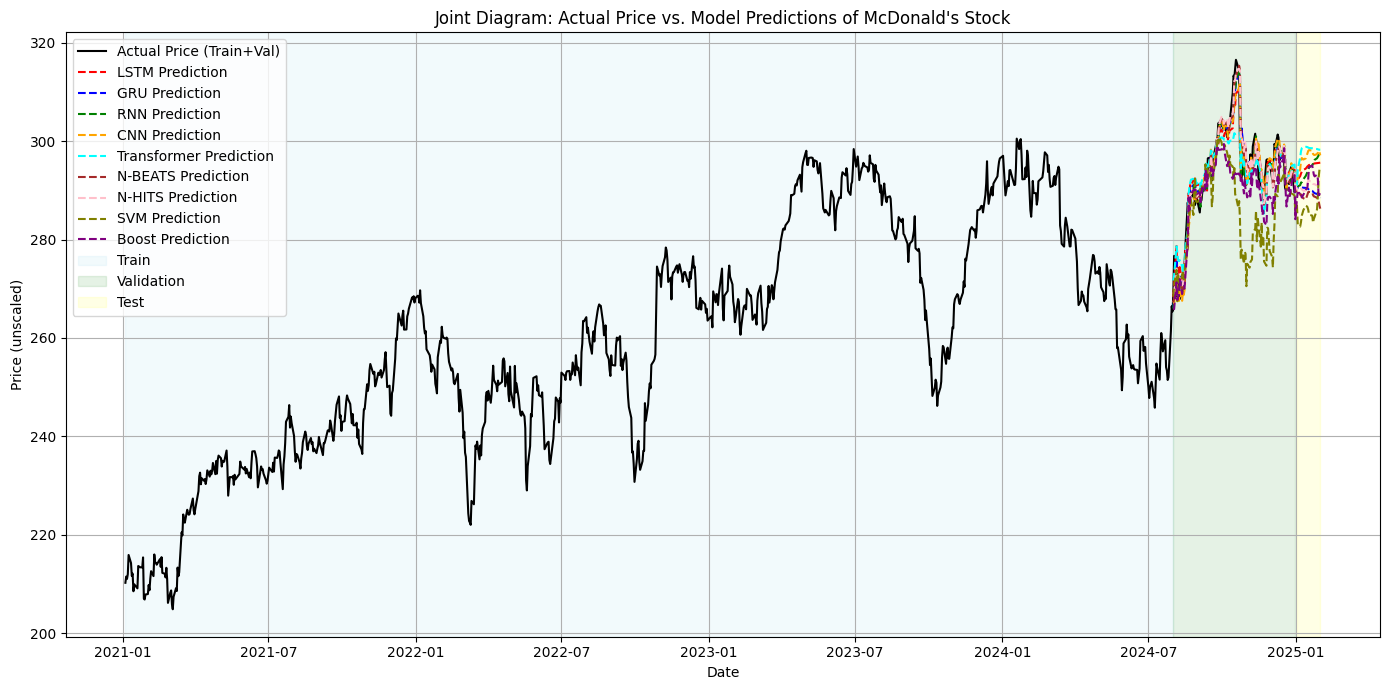

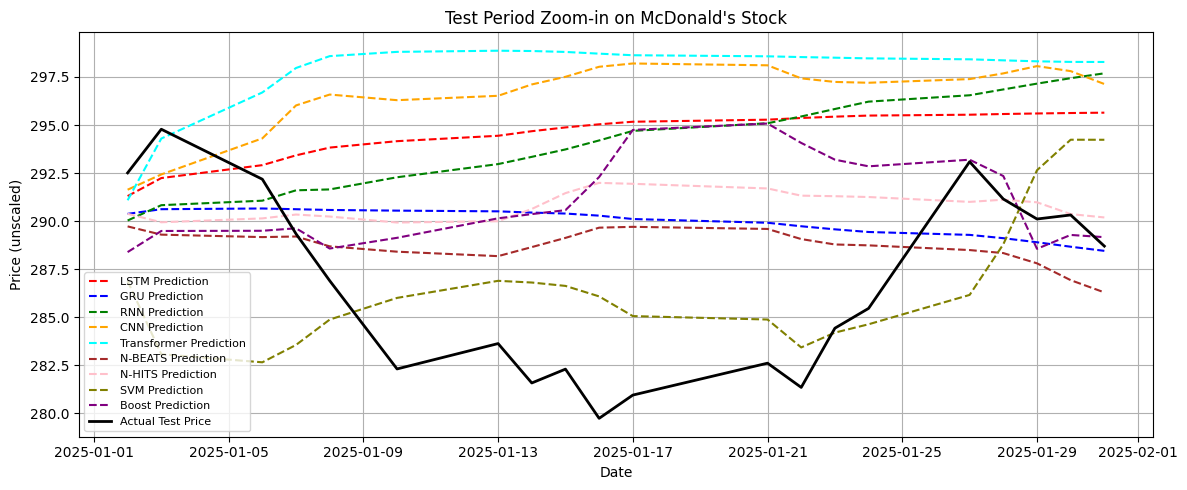

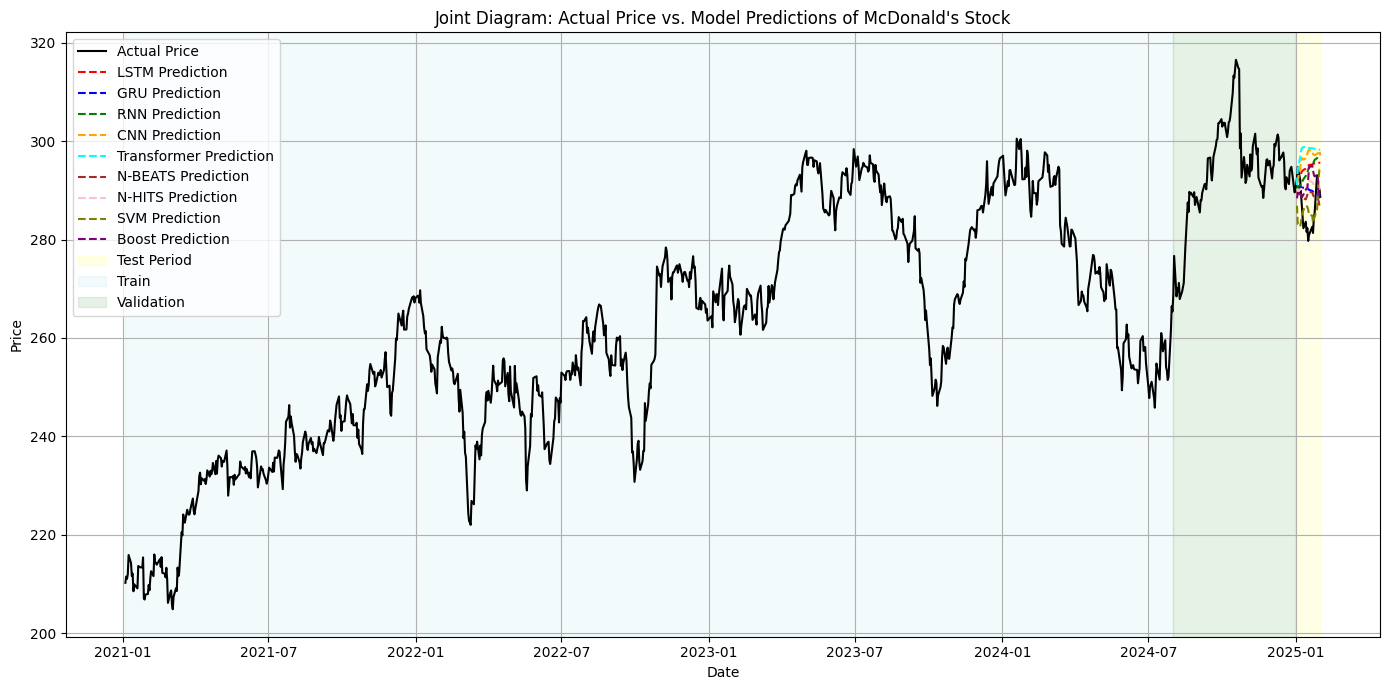

Model: LSTM - Cumulative Absolute Error: 165.6643
Model: GRU - Cumulative Absolute Error: 98.3098
Model: RNN - Cumulative Absolute Error: 166.3065
Model: CNN - Cumulative Absolute Error: 205.6970
Model: Transformer - Cumulative Absolute Error: 227.4086
Model: N-BEATS - Cumulative Absolute Error: 94.2706
Model: N-HITS - Cumulative Absolute Error: 105.0386
Model: SVM - Cumulative Absolute Error: 88.3029
Model: Boost - Cumulative Absolute Error: 116.4990


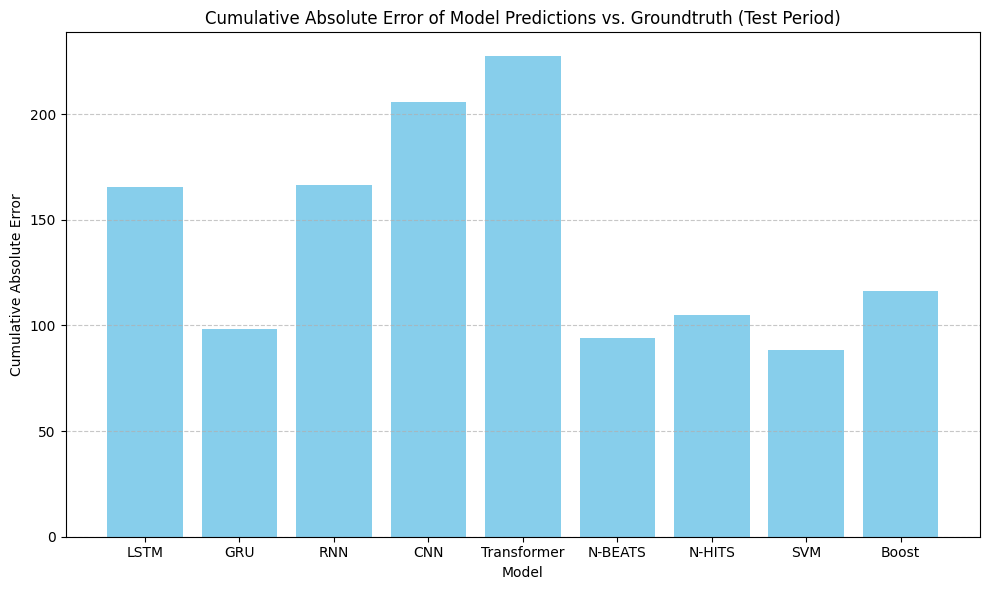

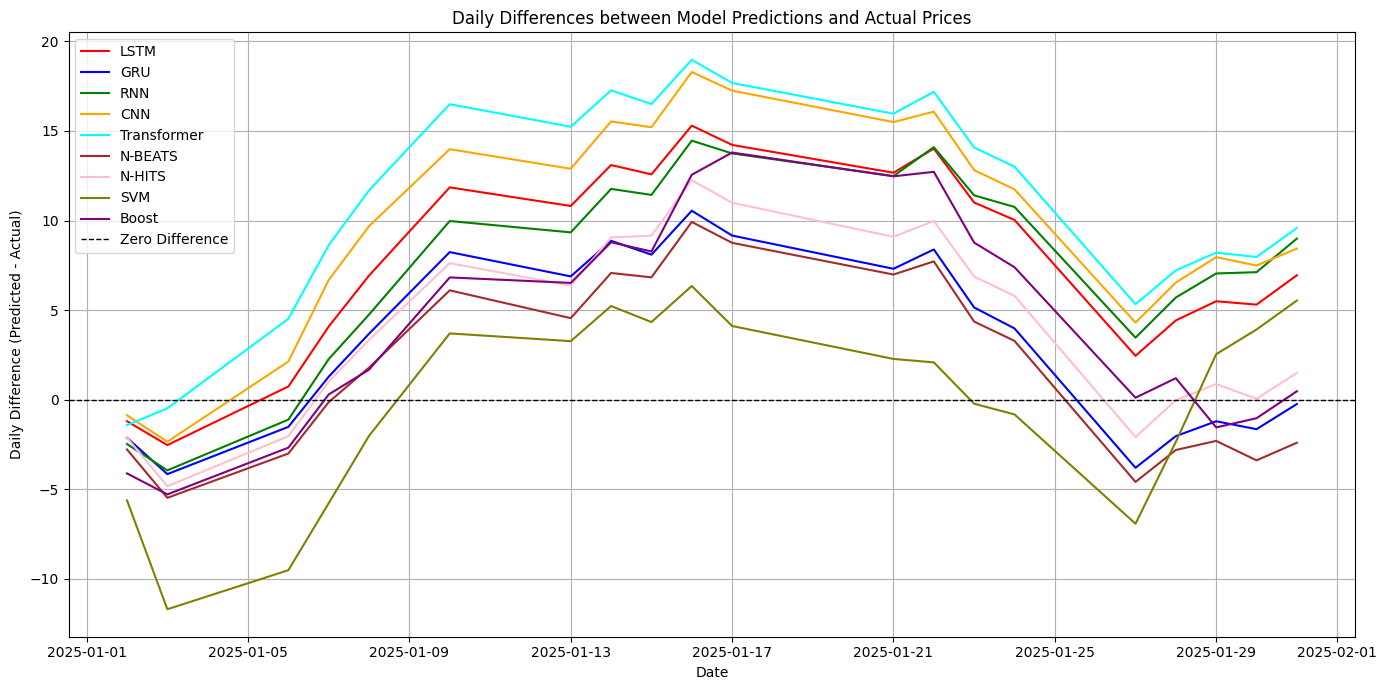

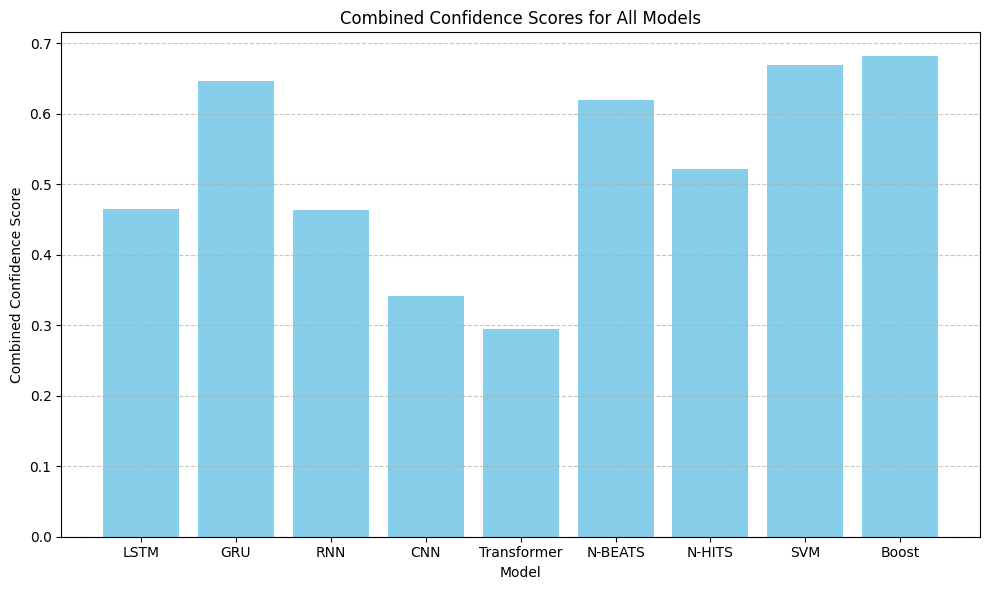

Normalized Confidence Scores for Top 5 Models (Sum = 1):
     Model  normalized_confidence
8    Boost               0.217176
7      SVM               0.213072
1      GRU               0.206192
5  N-BEATS               0.197225
6   N-HITS               0.166334

Selected models and their normalized confidence scores (ready for later polynomial fitting):
{'Boost': 0.21717619091941734, 'SVM': 0.2130718963322174, 'GRU': 0.20619247451275813, 'N-BEATS': 0.19722513851557286, 'N-HITS': 0.16633429972003427}
Polynomial-fitting test DataFrame columns: ['Date', 'Actual', 'Boost', 'SVM', 'GRU', 'N-BEATS', 'N-HITS']
Number of rows in polynomial-fitting test DataFrame: 20

=== Best Polynomial Orders (Test Window) ===
[Actual] -> Best Degree: 33, Val MSE = 4.558546
     Polynomial Expression: y = -1.0855e-129*x^33-1.3965e-126*x^32+1.8464e-121*x^31+5.4702e-117*x^30+1.1174e-112*x^29+1.7981e-108*x^28+2.1809e-104*x^27+1.0871e-100*x^26-3.6172e-96*x^25-1.8437e-91*x^24-5.2427e-87*x^23-1.2164e-82*x^22-2.4939e

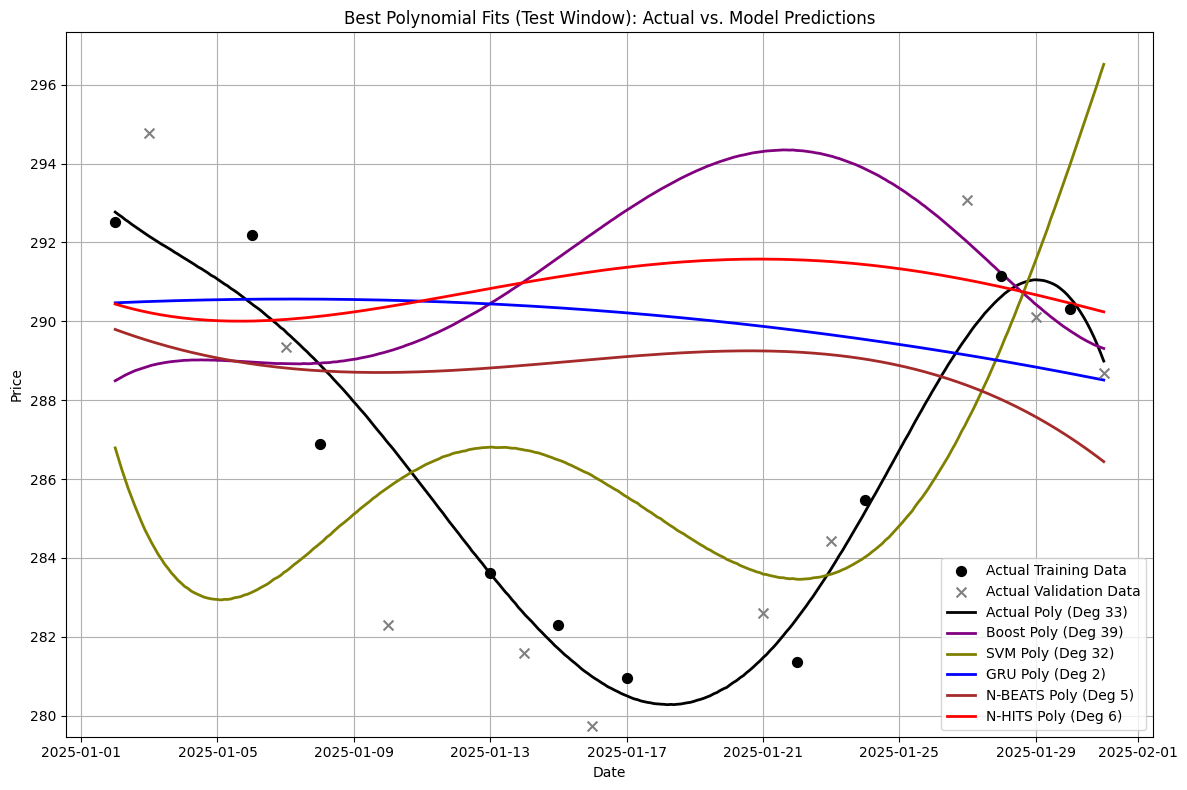

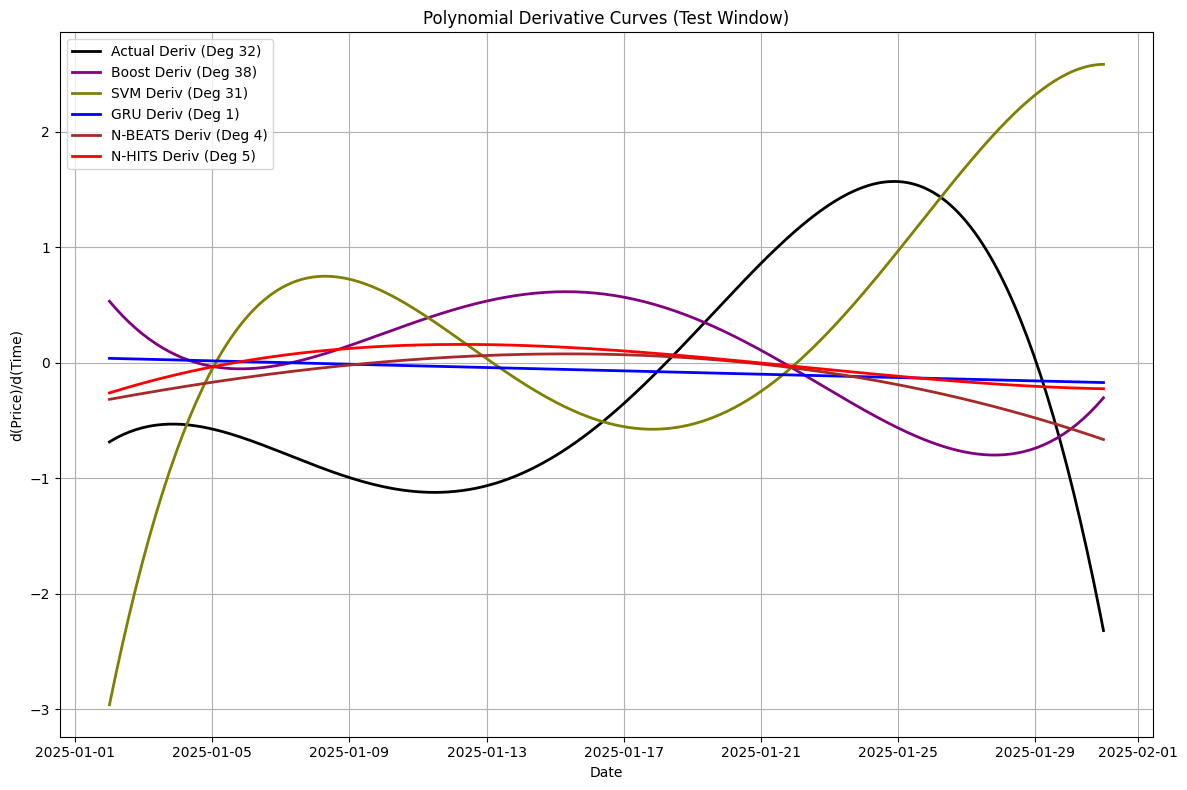


=== Derivative Polynomial Expressions ===
[Actual] (Degree 33) -> derivative: -3.5821e-128*x^32-4.4687e-125*x^31+5.7238e-120*x^30+1.6411e-115*x^29+3.2405e-111*x^28+5.0347e-107*x^27+5.8885e-103*x^26+2.8264e-99*x^25-9.0431e-95*x^24-4.4248e-90*x^23-1.2058e-85*x^22-2.6760e-81*x^21-5.2371e-77*x^20-9.0174e-73*x^19-1.3799e-68*x^18-1.6781e-64*x^17-1.1384e-60*x^16+2.0776e-56*x^15+1.1651e-51*x^14+3.3511e-47*x^13+7.8347e-43*x^12+1.6101e-38*x^11+2.8704e-34*x^10+4.5671e-30*x^9+5.7442e-26*x^8+4.4309e-22*x^7-4.8609e-18*x^6-3.1012e-13*x^5-8.4937e-09*x^4-1.6983e-04*x^3-2.5600e+00*x^2-2.2423e+04*x+4.9967e+07
[Boost] (Degree 39) -> derivative: 0.0000e+00*x^38-0.0000e+00*x^37-0.0000e+00*x^36-0.0000e+00*x^35+3.9247e-137*x^34+1.1031e-133*x^33-5.4044e-129*x^32-1.7615e-124*x^31-3.6190e-120*x^30-6.0964e-116*x^29-8.1724e-112*x^28-7.6457e-108*x^27+2.6177e-104*x^26+3.5853e-99*x^25+1.1248e-94*x^24+2.7886e-90*x^23+5.9416e-86*x^22+1.1174e-81*x^21+1.9355e-77*x^20+2.8437e-73*x^19+3.5217e-69*x^18+2.2246e-65*x^17-4.468

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib

# Additional imports for sklearn-based models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

###############################################################
# 1. Set random seeds
###############################################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################
# Global hyperparameters
###############################################################
WINDOW_SIZE = 35
NUM_EPOCHS  = 800

features = ["Price", "Open", "High", "Low"]
csv_file = "McDonald’s Stock Price History.csv"

###############################################################
# 2. Load & Clean CSV
###############################################################
df = pd.read_csv(csv_file)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# ------------------------------------------------------------------------
# 3. Date cutoffs: TRAIN, VAL, TEST
# ------------------------------------------------------------------------
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

###############################################################
# 4. Fit MinMaxScaler on TRAIN only
###############################################################
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward procedures)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###############################################################
# 5A. Create the training sequences
###############################################################
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# For sklearn-based models we flatten the time window.
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))
# y_train_all remains shape: (n_samples, 4)

###############################################################
# 5B. "Half-blind" validation loss function (for training)
###############################################################
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float).values
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

###############################################################
# 5C. "Half-blind" validation predictions (non-iterative version)
###############################################################
def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################
# NEW: Iterative (next-day) half-blind validation predictions
###############################################################
def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=WINDOW_SIZE):
    """
    Simulates a next-day (iterative) half-blind validation.
    It starts with the final training window (last WINDOW_SIZE rows before val_start),
    then for each validation day:
      - It uses the current window to predict the next day.
      - It then “unveils” the actual observation for that day from df_all_scaled.
      - The window is updated by dropping the oldest row and appending the actual observed row.
    """
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    # Identify the starting index for validation.
    val_idx = df_work.index[df_work["Date"] >= val_start]
    if len(val_idx) == 0:
        raise ValueError("No validation data available after val_start.")
    first_val_idx = val_idx[0]
    
    # Initialize current window from the last WINDOW_SIZE rows before validation starts.
    current_window = df_work.iloc[first_val_idx - window:first_val_idx][features].values
    preds = []
    
    # Get all validation dates in order.
    val_dates = np.sort(df_work[df_work["Date"] >= val_start]["Date"].unique())
    
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            # Use current window to predict next-day (day d) scaled values.
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
            
            # "Uncover" the actual observation for day d.
            actual_row = df_work[df_work["Date"] == d][features].values
            if actual_row.shape[0] == 0:
                continue
            actual = actual_row[0]
            # Update the window: remove oldest row and append the actual observation.
            current_window = np.vstack((current_window[1:], actual))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################
# 6. Define the base PyTorch model (supports several types)
###############################################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=WINDOW_SIZE):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == "LSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "GRU":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "RNN":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)  # [batch, window, 128]
            x = x.permute(1, 0, 2)      # [window, batch, 128]
            x = self.transformer_encoder(x)
            x = x[-1, :, :]            # last time step
            out = self.fc(x)
        elif self.model_type == "N-BEATS":
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        elif self.model_type == "N-HITS":
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

###############################################################
# Early Stopping class
###############################################################
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

###############################################################
# 7. Inverse transform helper
###############################################################
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

###############################################################
# 8. Training function for PyTorch models
###############################################################
def train_model(model_type="LSTM", num_epochs=NUM_EPOCHS):
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)
    best_path = f"best_{model_type}_McDonal_V1.pt"
    
    # If the best model file exists, load and return the model immediately.
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return model

    # Otherwise, train the model.
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)
    
    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        val_loss = half_blind_validation_loss(model, df_scaled, val_start=train_cutoff, val_end=val_cutoff, window=WINDOW_SIZE)
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)
        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break
        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

###############################################################
# 8B. Training function for sklearn-based models (SVM, GPR, Boost)
###############################################################
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        # x: [1, window, 4] tensor -> flatten to [1, window*4]
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1,4)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    best_path = f"best_{model_type}_McDonal_V1.pkl"
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type == "SVM":
            base_model = SVR(kernel='rbf', C=10.0, epsilon=0.01)
        elif model_type == "GPR":
            from sklearn.gaussian_process.kernels import RBF
            kernel = RBF(length_scale=1.0)
            base_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
        elif model_type == "Boost":
            base_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        else:
            raise ValueError("Unsupported sklearn model type")
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

###############################################################
# 9. Validation predictions + Test predictions
###############################################################
def walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]
            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################
# 10. Evaluate & Plot
###############################################################
def evaluate_and_plot_all_models(results_dict):
    # Get the actual (unscaled) train+val data.
    df_real = df_scaled[["Date", "Price", "Open", "High", "Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    # -------------------------------
    # Plot 1: Joint Diagram: Actual Price vs. Model Predictions
    # -------------------------------
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    
    # Merge predictions from all models.
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)
    
    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)
        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")
    
    # Plot model predictions.
    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(model_name, "gray"),
                     linestyle="--",
                     label=f"{model_name} Prediction")
    
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    
    plt.title("Joint Diagram: Actual Price vs. Model Predictions of McDonald's Stock")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Plot 2: Test Period Zoom-in (with Actual Test Prices)
    # -------------------------------
    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for model_name, info in results_dict.items():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(df_test_zoom["Date"], df_test_zoom[col],
                         color=color_map.get(model_name, "gray"),
                         linestyle="--",
                         label=f"{model_name} Prediction")
        # Load actual test prices from the complete CSV.
        df_complete = pd.read_csv("McDonald’s Stock Price History_Complete.csv")
        df_complete.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
        df_complete['Date'] = pd.to_datetime(df_complete['Date'])
        df_complete.sort_values("Date", inplace=True)
        df_test_actual = df_complete[df_complete["Date"] >= test_cutoff].copy()
        # Plot actual test price (assumed unscaled).
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color='black', linewidth=2, label='Actual Test Price')
        
        plt.title("Test Period Zoom-in on McDonald's Stock")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend(prop={'size':8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()

###############################################################
# 11. MAIN
###############################################################
if __name__ == "__main__":
    # List of all models to run (both PyTorch and sklearn-based)
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "Boost"]
    results_dict = {}
    
    for mt in all_model_types:
        print(f"\n=== Training {mt} model ===")
        if mt in ["SVM", "GPR", "Boost"]:
            model = train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model = train_model(mt, num_epochs=NUM_EPOCHS)
        
        # For models like SVM, Transformer, and Boost, use iterative (next-day) validation:
        if mt in ["SVM", "Transformer", "Boost"]:
            val_pred_df = iterative_half_blind_validation_preds(
                model,
                df_scaled,
                val_start=train_cutoff,  # start validation right after training
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        else:
            val_pred_df = half_blind_validation_preds_df(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        
        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )
        
        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} has no real test data => skip MAPE")
    
    evaluate_and_plot_all_models(results_dict)

# ================================
# Additional Plot: Joint Diagram of Actual vs. Predicted Prices
# ================================

# Load and prepare actual price data from another CSV
df_actual = pd.read_csv("McDonald’s Stock Price History_Complete.csv")
df_actual.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
df_actual['Date'] = pd.to_datetime(df_actual['Date'])
df_actual.sort_values(by='Date', ascending=True, inplace=True)
df_actual.reset_index(drop=True, inplace=True)

# Clean numerical columns: remove commas and convert to float
num_cols = df_actual.columns.drop("Date")
df_actual[num_cols] = df_actual[num_cols].replace({',': ''}, regex=True)
df_actual[num_cols] = df_actual[num_cols].astype('float64')

# Extract the actual price curve
actual_dates = df_actual['Date']
actual_prices = df_actual['Price']

# Prepare model prediction data from results_dict
# (Ensure each test_pred_df has its Date column as datetime)
for model_name, pred_info in results_dict.items():
    if pred_info["test_pred_df"] is not None and not pred_info["test_pred_df"].empty:
        pred_info["test_pred_df"]['Date'] = pd.to_datetime(pred_info["test_pred_df"]['Date'])

# Plot the joint diagram
plt.figure(figsize=(14, 7))
# Plot actual prices (from the complete CSV)
plt.plot(actual_dates, actual_prices, color='black', linewidth=1.5, label='Actual Price')

# Define custom colors for each model prediction
model_colors = {
    "LSTM": "red",
    "GRU": "blue",
    "RNN": "green",
    "CNN": "orange",
    "Transformer": "cyan",
    "N-BEATS": "brown",
    "N-HITS": "pink",
    "SVM": "olive",
    "Boost": "purple"
}

# Overlay each model's test predictions
for model_name, pred_info in results_dict.items():
    test_df = pred_info["test_pred_df"]
    if test_df is not None and not test_df.empty:
        plt.plot(pd.to_datetime(test_df["Date"]), test_df["Pred_Price_unscaled"],
                 color=model_colors.get(model_name, "gray"),
                 linestyle="--", linewidth=1.5,
                 label=f'{model_name} Prediction')

# Optionally, highlight the test period (adjust the start date as needed)
test_period_start = pd.to_datetime("2025-01-02")
plt.axvspan(test_period_start, actual_dates.iloc[-1], color='yellow', alpha=0.1, label='Test Period')
plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")

plt.title("Joint Diagram: Actual Price vs. Model Predictions of McDonald's Stock")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# %% [markdown]
# ### Additional Cell: Groundtruth Comparison & Cumulative Absolute Error Calculation

# %% [code]
# Load groundtruth actual test prices from the complete CSV
df_groundtruth = pd.read_csv("McDonald’s Stock Price History_Complete.csv")
df_groundtruth.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
df_groundtruth['Date'] = pd.to_datetime(df_groundtruth['Date'])
df_groundtruth.sort_values("Date", inplace=True)
df_groundtruth.reset_index(drop=True, inplace=True)

# Filter the data to only include the test period (dates >= test_cutoff)
df_groundtruth_test = df_groundtruth[df_groundtruth["Date"] >= test_cutoff][["Date", "Price"]].copy()

# Dictionary to store cumulative absolute errors for each model
cumulative_errors = {}

# Iterate through each model's test predictions in the results_dict
for model_name, info in results_dict.items():
    test_pred_df = info.get("test_pred_df")
    if test_pred_df is not None and not test_pred_df.empty:
        # Ensure the Date column is datetime format
        test_pred_df["Date"] = pd.to_datetime(test_pred_df["Date"])
        # Merge the model's predictions with the groundtruth data on Date
        df_merge = pd.merge(test_pred_df, df_groundtruth_test, on="Date", how="inner")
        if not df_merge.empty:
            # Calculate the absolute error between the predicted unscaled price and the actual price
            df_merge["Abs_Error"] = np.abs(df_merge["Pred_Price_unscaled"] - df_merge["Price"])
            # Sum the absolute errors over the test period to get cumulative error
            cumulative_error = df_merge["Abs_Error"].sum()
            cumulative_errors[model_name] = cumulative_error
            print(f"Model: {model_name} - Cumulative Absolute Error: {cumulative_error:.4f}")
        else:
            print(f"Model: {model_name} - No matching dates with groundtruth for the test period.")
    else:
        print(f"Model: {model_name} - No test predictions available.")

# Plot the cumulative absolute errors as a bar chart
if cumulative_errors:
    plt.figure(figsize=(10, 6))
    model_names = list(cumulative_errors.keys())
    errors = [cumulative_errors[m] for m in model_names]
    plt.bar(model_names, errors, color='skyblue')
    plt.xlabel("Model")
    plt.ylabel("Cumulative Absolute Error")
    plt.title("Cumulative Absolute Error of Model Predictions vs. Groundtruth (Test Period)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ### Additional Cell: Daily Difference Diagram (Predicted - Actual)

# %% [code]
# Ensure groundtruth test data is available
if 'df_groundtruth_test' not in globals():
    df_groundtruth = pd.read_csv("McDonald’s Stock Price History_Complete.csv")
    df_groundtruth.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    df_groundtruth['Date'] = pd.to_datetime(df_groundtruth['Date'])
    df_groundtruth.sort_values("Date", inplace=True)
    df_groundtruth.reset_index(drop=True, inplace=True)
    df_groundtruth_test = df_groundtruth[df_groundtruth["Date"] >= test_cutoff][["Date", "Price"]].copy()

plt.figure(figsize=(14, 7))

# Use a consistent color mapping for clarity
model_colors = {
    "LSTM": "red",
    "GRU": "blue",
    "RNN": "green",
    "CNN": "orange",
    "Transformer": "cyan",
    "N-BEATS": "brown",
    "N-HITS": "pink",
    "SVM": "olive",
    "Boost": "purple"
}

# Iterate through each model in results_dict
for model_name, info in results_dict.items():
    test_pred_df = info.get("test_pred_df")
    if test_pred_df is None or test_pred_df.empty:
        continue
    # Ensure Date column is datetime format
    test_pred_df["Date"] = pd.to_datetime(test_pred_df["Date"])
    # Merge with groundtruth based on Date
    df_merge = pd.merge(test_pred_df, df_groundtruth_test, on="Date", how="inner")
    if df_merge.empty:
        continue
    df_merge.sort_values("Date", inplace=True)
    # Calculate daily difference: predicted unscaled price minus actual price
    df_merge["Difference"] = df_merge["Pred_Price_unscaled"] - df_merge["Price"]
    color = model_colors.get(model_name, None)
    plt.plot(df_merge["Date"], df_merge["Difference"], label=model_name, color=color)

# Draw a horizontal line at zero difference
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Difference")
plt.xlabel("Date")
plt.ylabel("Daily Difference (Predicted - Actual)")
plt.title("Daily Differences between Model Predictions and Actual Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# %% [markdown]
# ### Additional Cell: Model Selection Based on Trend Matching & Confidence Score

# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load groundtruth test data (if not already loaded)
df_groundtruth = pd.read_csv("McDonald’s Stock Price History_Complete.csv")
df_groundtruth.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
df_groundtruth['Date'] = pd.to_datetime(df_groundtruth['Date'])
df_groundtruth.sort_values("Date", inplace=True)
df_groundtruth.reset_index(drop=True, inplace=True)

# Filter to test period (dates >= test_cutoff)
df_groundtruth_test = df_groundtruth[df_groundtruth["Date"] >= test_cutoff][["Date", "Price"]].copy()

# Dictionary to store metrics for each model
model_metrics = {}

# Iterate through each model in results_dict
for model_name, info in results_dict.items():
    test_pred_df = info.get("test_pred_df")
    if test_pred_df is None or test_pred_df.empty:
        print(f"Model: {model_name} - No test predictions available.")
        continue
    # Ensure Date column is datetime type
    test_pred_df["Date"] = pd.to_datetime(test_pred_df["Date"])
    # Merge model predictions with groundtruth data on Date
    df_merge = pd.merge(test_pred_df, df_groundtruth_test, on="Date", how="inner")
    if df_merge.empty:
        print(f"Model: {model_name} - No matching dates with groundtruth for the test period.")
        continue
    # Sort by Date to ensure proper chronological order
    df_merge.sort_values("Date", inplace=True)
    
    # --- Metric 1: Cumulative Absolute Error ---
    df_merge["Abs_Error"] = np.abs(df_merge["Pred_Price_unscaled"] - df_merge["Price"])
    cumulative_error = df_merge["Abs_Error"].sum()
    
    # --- Metric 2: Trend Matching Rate ---
    # Calculate day-to-day differences for actual and predicted prices
    df_merge["Actual_Diff"] = df_merge["Price"].diff()
    df_merge["Pred_Diff"] = df_merge["Pred_Price_unscaled"].diff()
    # Exclude the first day (NaN in diff)
    df_valid = df_merge.dropna(subset=["Actual_Diff", "Pred_Diff"]).copy()
    
    # Define a helper to determine if the trend signs match.
    # We treat a day as matching if both differences have the same sign,
    # or if both are zero.
    def sign_match(a, b):
        if a == 0 and b == 0:
            return 1
        return 1 if np.sign(a) == np.sign(b) else 0
    
    df_valid["Trend_Match"] = df_valid.apply(lambda row: sign_match(row["Actual_Diff"], row["Pred_Diff"]), axis=1)
    if len(df_valid) > 0:
        trend_matching_rate = df_valid["Trend_Match"].mean()  # fraction of days matching trend
    else:
        trend_matching_rate = 0.0
    
    # Store the computed metrics for this model
    model_metrics[model_name] = {
        "cumulative_error": cumulative_error,
        "trend_matching_rate": trend_matching_rate
    }

# --- Normalize the Cumulative Error ---
# Lower cumulative error is better; so we convert errors into a normalized score (0 to 1),
# where 1 indicates the best (lowest error) among the models.
if model_metrics:
    cum_errors = [metrics["cumulative_error"] for metrics in model_metrics.values()]
    min_error = min(cum_errors)
    max_error = max(cum_errors)
    for model_name, metrics in model_metrics.items():
        if max_error > min_error:
            normalized_error_score = 1 - ((metrics["cumulative_error"] - min_error) / (max_error - min_error))
        else:
            normalized_error_score = 1  # all models have identical errors
        model_metrics[model_name]["normalized_error_score"] = normalized_error_score
        
        # --- Combined Confidence Score ---
        # We weight trend matching at 70% and normalized error at 30%.
        combined_confidence = 0.7 * metrics["trend_matching_rate"] + 0.3 * normalized_error_score
        model_metrics[model_name]["combined_confidence"] = combined_confidence

# Convert the metrics dictionary into a DataFrame for easier viewing
df_metrics = pd.DataFrame.from_dict(model_metrics, orient="index")
df_metrics.reset_index(inplace=True)
df_metrics.rename(columns={"index": "Model"}, inplace=True)

#print("Model Metrics for Trend Matching & Confidence:")
#print(df_metrics)

# --- Select Top 5 Models Based on Combined Confidence ---
top5_models = df_metrics.sort_values("combined_confidence", ascending=False).head(5)
#print("\nTop 5 Selected Models:")
#print(top5_models)

# --- Plot Combined Confidence Scores ---
plt.figure(figsize=(10,6))
plt.bar(df_metrics["Model"], df_metrics["combined_confidence"], color='skyblue')
plt.xlabel("Model")
plt.ylabel("Combined Confidence Score")
plt.title("Combined Confidence Scores for All Models")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Evidence Summary ---

# %% [markdown]
# ### Additional Cell: Re-normalize Confidence Scores for Selected Models

# %% [code]
# Assuming 'top5_models' DataFrame is already computed from the previous cell.
if not top5_models.empty:
    # Re-normalize the combined confidence scores so the sum equals 1.
    total_confidence = top5_models["combined_confidence"].sum()
    top5_models["normalized_confidence"] = top5_models["combined_confidence"] / total_confidence
    print("Normalized Confidence Scores for Top 5 Models (Sum = 1):")
    print(top5_models[["Model", "normalized_confidence"]])
    
    # Prepare a dictionary for later use (e.g., in polynomial fitting routines)
    selected_models_confidence = dict(zip(top5_models["Model"], top5_models["normalized_confidence"]))
    print("\nSelected models and their normalized confidence scores (ready for later polynomial fitting):")
    print(selected_models_confidence)
else:
    print("No top models available to normalize confidence scores.")


import warnings
warnings.filterwarnings("ignore")  # Ignore all warning messages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

# -------------------------------
# Preliminary Setup
# -------------------------------
# Define test_cutoff if not already defined
try:
    test_cutoff
except NameError:
    test_cutoff = pd.to_datetime("2025-01-02")

# Load complete CSV and define df_test_actual if not already defined
try:
    df_test_actual
except NameError:
    df_complete = pd.read_csv("McDonald’s Stock Price History_Complete.csv")
    df_complete.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    df_complete['Date'] = pd.to_datetime(df_complete['Date'])
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)
    # Filter to test period (dates >= test_cutoff)
    df_test_actual = df_complete[df_complete["Date"] >= test_cutoff].copy()

# -------------------------------
# 1) Gather Test Data: Actual vs. Top-5 Model Predictions
# -------------------------------
# Create a DataFrame from the groundtruth test data
df_test_poly = df_test_actual[["Date", "Price"]].rename(columns={"Price": "Actual"}).copy()
df_test_poly.sort_values("Date", inplace=True)

# Use the best models from your prior selection.
# If you previously computed normalized confidences and stored them in selected_models_confidence,
# then we can use its keys. Otherwise, fall back to all models in results_dict.
try:
    best_model_names = list(selected_models_confidence.keys())
except NameError:
    best_model_names = list(results_dict.keys()) if "results_dict" in globals() else []

# Merge each model's predictions (assumed to be in the "Pred_Price_unscaled" column) into df_test_poly.
for model_name in best_model_names:
    if "results_dict" in globals():
        pred_df = results_dict[model_name]["test_pred_df"]
    else:
        pred_df = None
    if pred_df is not None and not pred_df.empty:
        df_test_poly = pd.merge(
            df_test_poly,
            pred_df[["Date", "Pred_Price_unscaled"]],
            on="Date", how="left"
        ).rename(columns={"Pred_Price_unscaled": model_name})

# Drop rows with missing data in any column
df_test_poly.dropna(axis=0, how="any", inplace=True)
df_test_poly.reset_index(drop=True, inplace=True)

print("Polynomial-fitting test DataFrame columns:", df_test_poly.columns.tolist())
print("Number of rows in polynomial-fitting test DataFrame:", len(df_test_poly))

# -------------------------------
# 2) Create Train/Validation Masks (Every Second Day for Validation)
# -------------------------------
n_points = len(df_test_poly)
indices = np.arange(n_points)
# Use even-indexed rows for training and odd-indexed rows for validation.
training_mask = (indices % 2 == 0)
validation_mask = ~training_mask

# Convert dates to a numeric axis for polynomial fitting.
df_test_poly["mdates_num"] = mdates.date2num(df_test_poly["Date"])

# -------------------------------
# 3) For Each Column, Select Best Polynomial Degree (1 to 35)
# -------------------------------
def format_polynomial(coeffs):
    """
    Convert polynomial coefficients (highest degree first)
    into a readable expression.
    """
    terms = []
    degree = len(coeffs) - 1
    for i, c in enumerate(coeffs):
        power = degree - i
        if power > 1:
            terms.append(f"{c:+.4e}*x^{power}")
        elif power == 1:
            terms.append(f"{c:+.4e}*x")
        else:
            terms.append(f"{c:+.4e}")
    expr = "".join(terms).replace("+-", "-")
    if expr.startswith("+"):
        expr = expr[1:]
    return expr

# Dictionary to store best-fit info for each column.
best_poly_info = {}
# Consider polynomial degrees from 1 to 50.
poly_degree_candidates = range(1, 50)
# Columns to fit: "Actual" and each model's column.
columns_to_fit = ["Actual"] + best_model_names

for col in columns_to_fit:
    x_train = df_test_poly.loc[training_mask, "mdates_num"].values
    y_train = df_test_poly.loc[training_mask, col].values
    x_val = df_test_poly.loc[validation_mask, "mdates_num"].values
    y_val = df_test_poly.loc[validation_mask, col].values
    
    best_val_mse = float("inf")
    best_degree = None
    best_coeffs = None
    for d in poly_degree_candidates:
        coeffs = np.polyfit(x_train, y_train, d)
        y_val_pred = np.polyval(coeffs, x_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_degree = d
            best_coeffs = coeffs
    best_poly_info[col] = {"degree": best_degree, "coeffs": best_coeffs, "val_mse": best_val_mse}

# -------------------------------
# 4) Print Each Column's Best Polynomial Information
# -------------------------------
print("\n=== Best Polynomial Orders (Test Window) ===")
for col in columns_to_fit:
    info = best_poly_info[col]
    deg = info["degree"]
    mse = info["val_mse"]
    coeffs = info["coeffs"]
    expr = format_polynomial(coeffs)
    print(f"[{col}] -> Best Degree: {deg}, Val MSE = {mse:.6f}")
    print(f"     Polynomial Expression: y = {expr}\n")

# -------------------------------
# 5) Joint Plot: Overlay Best-Fitting Polynomial Curves for All Columns
# -------------------------------
plt.figure(figsize=(12, 8))
# Plot the actual datapoints with classification:
plt.scatter(df_test_poly.loc[training_mask, "Date"], df_test_poly.loc[training_mask, "Actual"],
            color="black", marker="o", s=50, label="Actual Training Data", zorder=5)
plt.scatter(df_test_poly.loc[validation_mask, "Date"], df_test_poly.loc[validation_mask, "Actual"],
            color="gray", marker="x", s=50, label="Actual Validation Data", zorder=5)

# Define colors for polynomial curves (for Actual and each model).
colors = {"Actual": "black"}
default_colors = ["purple", "olive", "blue", "brown", "red"]
for i, model_name in enumerate(best_model_names):
    colors[model_name] = default_colors[i % len(default_colors)]

# Create a dense x-axis for plotting the polynomial curves.
x_dense = np.linspace(df_test_poly["mdates_num"].min(), df_test_poly["mdates_num"].max(), 300)
x_dense_dates = [mdates.num2date(xx) for xx in x_dense]

# For each column, evaluate its best-fit polynomial and plot it.
for col in columns_to_fit:
    info = best_poly_info[col]
    coeffs = info["coeffs"]
    y_dense = np.polyval(coeffs, x_dense)
    plt.plot(x_dense_dates, y_dense, color=colors[col], linewidth=2,
             label=f"{col} Poly (Deg {info['degree']})")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Best Polynomial Fits (Test Window): Actual vs. Model Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 6) (Optional) Joint Plot of Derivative Curves & Print Their Expressions
# -------------------------------
def derivative_expression(coeffs):
    d_coeffs = np.polyder(coeffs)
    return format_polynomial(d_coeffs)

plt.figure(figsize=(12, 8))
for col in columns_to_fit:
    info = best_poly_info[col]
    coeffs = info["coeffs"]
    d_coeffs = np.polyder(coeffs)
    d_coeffs = np.polyder(coeffs)
    y_deriv = np.polyval(d_coeffs, x_dense)
    plt.plot(x_dense_dates, y_deriv, color=colors[col], linewidth=2,
             label=f"{col} Deriv (Deg {info['degree']-1})")
plt.xlabel("Date")
plt.ylabel("d(Price)/d(Time)")
plt.title("Polynomial Derivative Curves (Test Window)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n=== Derivative Polynomial Expressions ===")
for col in columns_to_fit:
    d_expr = derivative_expression(best_poly_info[col]["coeffs"])
    print(f"[{col}] (Degree {best_poly_info[col]['degree']}) -> derivative: {d_expr}")



=== Trading Strategy Summary ===

Naive Optimistic Strategy:
Final Cumulative Raw P&L: -9.9700
Final Cumulative % Return: -3.44%

Naive Conservative Strategy:
Final Cumulative Raw P&L: -3.0800
Final Cumulative % Return: -1.09%

Daily Signal Counts (Optimistic):
Optimistic
 1    18
-1     1
Name: count, dtype: int64

Daily Signal Counts (Conservative):
Conservative
 0    18
-1     1
Name: count, dtype: int64


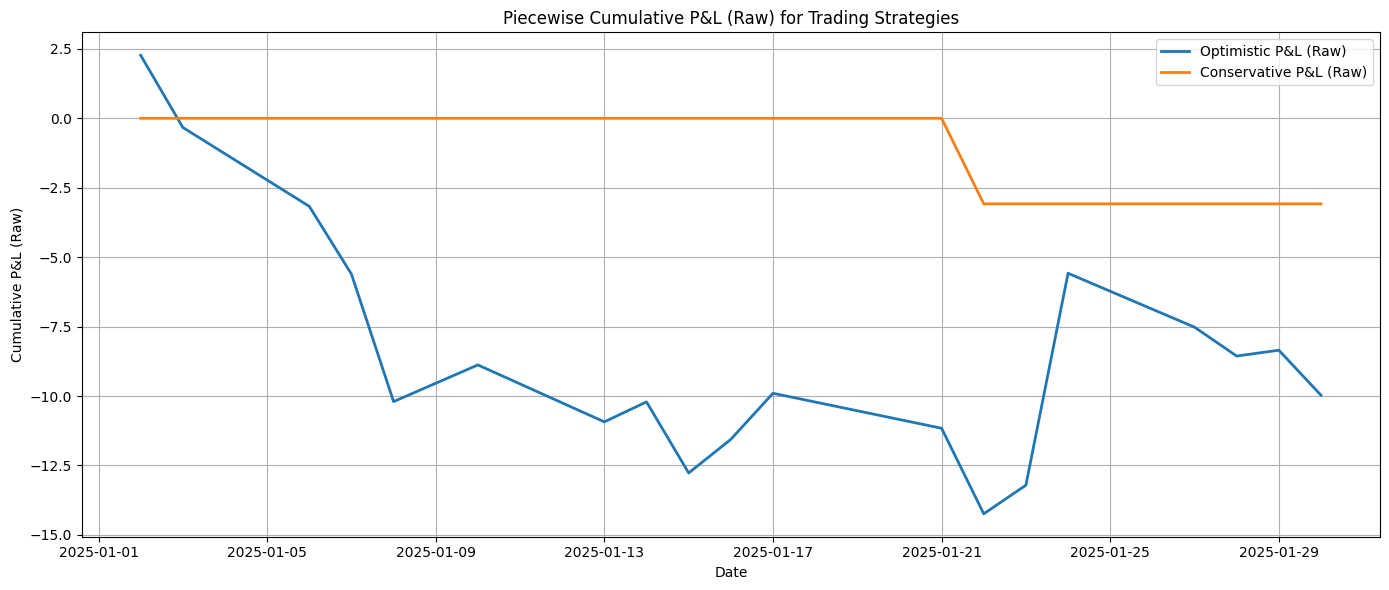

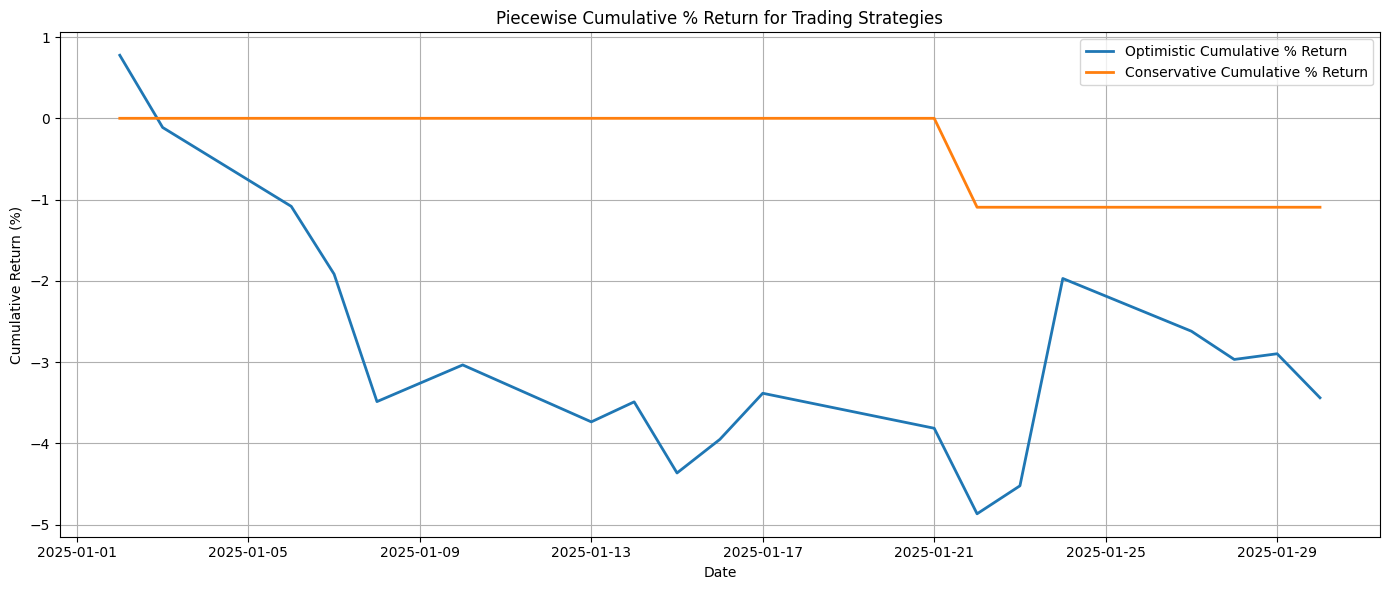

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ============================================================================
# 1. Evaluate the polynomial derivatives (gradients) for each best model
# ============================================================================
# For each best model, compute its derivative polynomial coefficients.
# We then evaluate the derivative at each date (using the numeric date: mdates_num)
for model in best_model_names:
    # Retrieve the polynomial coefficients (highest degree first) from our best fit
    coeffs = best_poly_info[model]["coeffs"]
    # Compute derivative coefficients (gradient polynomial)
    deriv_coeffs = np.polyder(coeffs)
    # Evaluate derivative for each test date and store in a new column
    col_name = f"{model}_deriv"
    df_test_poly[col_name] = np.polyval(deriv_coeffs, df_test_poly["mdates_num"])

# ============================================================================
# 2. Compute Daily Trading Signals for Each Strategy
# ============================================================================
# For each day (row), we decide on a signal from the best models’ gradients.
# -- Naive Optimistic: If ANY model’s gradient is > 0, signal long (+1);
#    else if (no positive) but ANY model’s gradient is < 0, signal short (-1);
#    otherwise, no position (0).
# -- Naive Conservative: If ALL models’ gradients are > 0, signal long (+1);
#    if ALL are < 0, signal short (-1); otherwise, no position (0).

def compute_signals(row):
    # Gather derivative values for the best models for this day
    deriv_values = [row[f"{model}_deriv"] for model in best_model_names]
    
    # Naive Optimistic: (optimistic bias: positive takes precedence)
    if any(val > 0 for val in deriv_values):
        opt_signal = 1
    elif any(val < 0 for val in deriv_values):
        opt_signal = -1
    else:
        opt_signal = 0

    # Naive Conservative: require unanimity
    if all(val > 0 for val in deriv_values):
        cons_signal = 1
    elif all(val < 0 for val in deriv_values):
        cons_signal = -1
    else:
        cons_signal = 0

    return pd.Series({'Optimistic': opt_signal, 'Conservative': cons_signal})

# Apply the function row-wise on the test DataFrame.
signals = df_test_poly.apply(compute_signals, axis=1)
df_test_poly = pd.concat([df_test_poly, signals], axis=1)

# ============================================================================
# 3. Simulate Trading
# ============================================================================
# We assume that the trading signal for day 't' is used to hold a position
# from day 't' to day 't+1'. We use the Actual price from the test groundtruth.
# For each day t (except the last), we compute:
#   - Daily raw P&L = signal * (Price[t+1] - Price[t])
#   - Daily % Return = signal * ((Price[t+1] - Price[t]) / Price[t])
#
# Then, we compute cumulative P&L (raw) by summing daily P&L and cumulative 
# % return by compounding daily returns (starting from 0% gain).

# Create a trading simulation DataFrame (exclude the last day as no next-day return)
df_trading = df_test_poly.copy().reset_index(drop=True)
df_trading = df_trading.iloc[:-1].copy()

# Next-day Actual price (to compute returns)
df_trading['Next_Actual'] = df_test_poly["Actual"].shift(-1).iloc[:-1].values

# Price change and percentage change
df_trading['Price_Change'] = df_trading['Next_Actual'] - df_trading['Actual']
df_trading['Price_Return'] = df_trading['Price_Change'] / df_trading['Actual']

# For each strategy, compute daily P&L and daily return.
df_trading['Pnl_Optimistic'] = df_trading['Optimistic'] * df_trading['Price_Change']
df_trading['Pnl_Conservative'] = df_trading['Conservative'] * df_trading['Price_Change']
df_trading['Return_Optimistic'] = df_trading['Optimistic'] * df_trading['Price_Return']
df_trading['Return_Conservative'] = df_trading['Conservative'] * df_trading['Price_Return']

# Compute cumulative raw P&L (simple sum) and cumulative % return (compounded).
df_trading['Cumulative_Pnl_Optimistic'] = df_trading['Pnl_Optimistic'].cumsum()
df_trading['Cumulative_Pnl_Conservative'] = df_trading['Pnl_Conservative'].cumsum()
# For % returns, assume an initial capital of 1. The cumulative return is:
df_trading['Cumulative_Return_Optimistic'] = (1 + df_trading['Return_Optimistic']).cumprod() - 1
df_trading['Cumulative_Return_Conservative'] = (1 + df_trading['Return_Conservative']).cumprod() - 1

# ============================================================================
# 4. Print Relevant Information
# ============================================================================
print("=== Trading Strategy Summary ===")
print("\nNaive Optimistic Strategy:")
print("Final Cumulative Raw P&L: {:.4f}".format(df_trading['Cumulative_Pnl_Optimistic'].iloc[-1]))
print("Final Cumulative % Return: {:.2%}".format(df_trading['Cumulative_Return_Optimistic'].iloc[-1]))

print("\nNaive Conservative Strategy:")
print("Final Cumulative Raw P&L: {:.4f}".format(df_trading['Cumulative_Pnl_Conservative'].iloc[-1]))
print("Final Cumulative % Return: {:.2%}".format(df_trading['Cumulative_Return_Conservative'].iloc[-1]))

# Optionally, you may also print daily signal statistics:
print("\nDaily Signal Counts (Optimistic):")
print(df_trading['Optimistic'].value_counts())
print("\nDaily Signal Counts (Conservative):")
print(df_trading['Conservative'].value_counts())

# ============================================================================
# 5. Plot the Piecewise Cumulative P&L (Raw) and Cumulative % Return
# ============================================================================
plt.figure(figsize=(14, 6))
plt.plot(df_trading["Date"], df_trading["Cumulative_Pnl_Optimistic"], label="Optimistic P&L (Raw)", linewidth=2)
plt.plot(df_trading["Date"], df_trading["Cumulative_Pnl_Conservative"], label="Conservative P&L (Raw)", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Cumulative P&L (Raw)")
plt.title("Piecewise Cumulative P&L (Raw) for Trading Strategies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(df_trading["Date"], df_trading["Cumulative_Return_Optimistic"] * 100, label="Optimistic Cumulative % Return", linewidth=2)
plt.plot(df_trading["Date"], df_trading["Cumulative_Return_Conservative"] * 100, label="Conservative Cumulative % Return", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.title("Piecewise Cumulative % Return for Trading Strategies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Composite Confidences for Each Model:
Boost: 0.4006
SVM: 0.0852
GRU: 0.6825
N-BEATS: 0.6175
N-HITS: 0.6205

=== New Trading Strategy Summary ===
Final Cumulative Raw PnL: -5.7900
Final Cumulative % Return: -2.10%

Daily Signal Counts:
Signal
-1    8
 1    6
 0    5
Name: count, dtype: int64


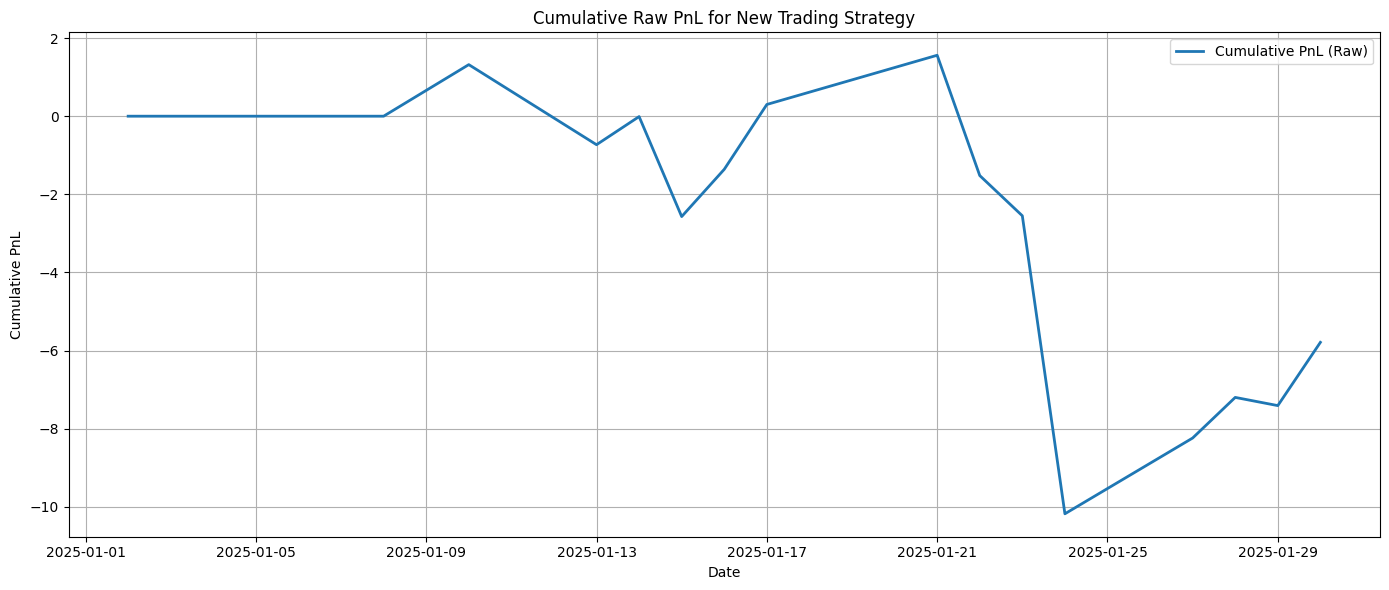

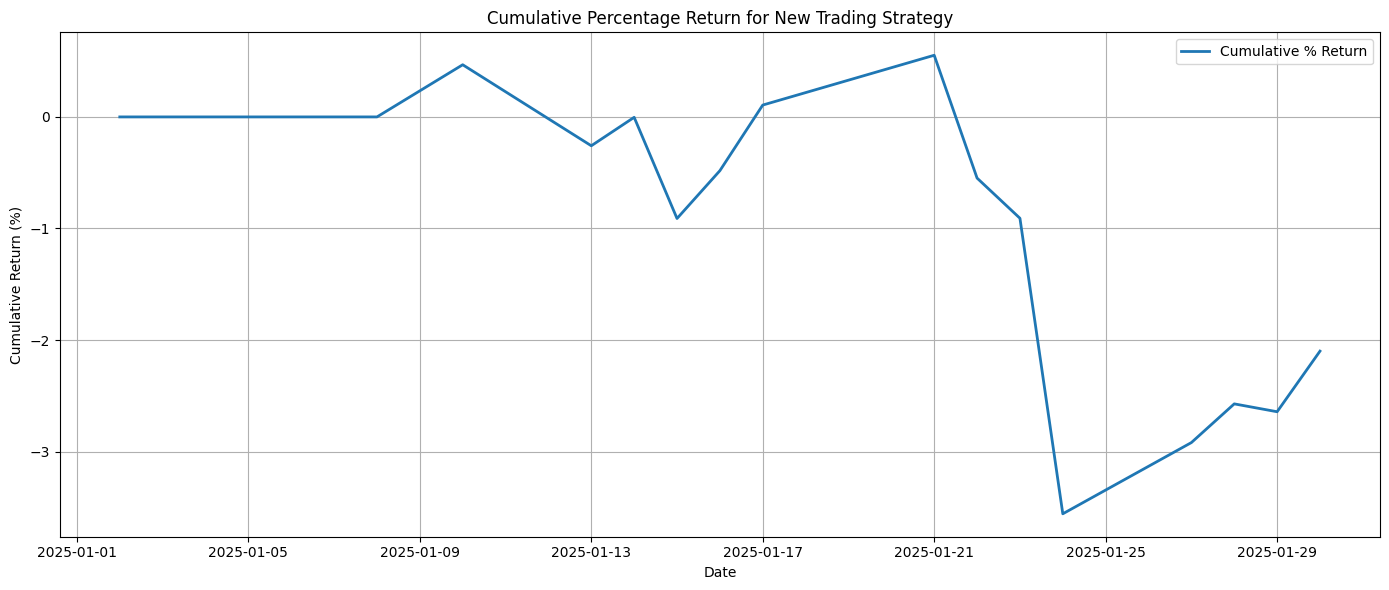

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ============================================================================
# 1. Compute Additional Confidence Levels for Each Best Model
# ============================================================================
# Assume:
# - best_model_names: list of model names (e.g., ['LSTM','GRU','RNN','CNN','Transformer'])
# - selected_models_confidence: dictionary with first confidence per model (from population vote)
# - best_poly_info: dictionary keyed by model name with best polynomial information including "val_mse"
# - df_test_poly: DataFrame for test period with column "mdates_num" (numeric dates) and "Actual" price.

# -- First Confidence Level --
# (Already available in selected_models_confidence)
# For example, if not defined, you could define:
# selected_models_confidence = {"LSTM": 0.25, "GRU": 0.20, "RNN": 0.15, "CNN": 0.20, "Transformer": 0.20}

# -- Second Confidence Level: Based on validation MSE --
val_mses = {model: best_poly_info[model]["val_mse"] for model in best_model_names}
min_val_mse = min(val_mses.values())
max_val_mse = max(val_mses.values())
second_conf = {}
for model in best_model_names:
    if max_val_mse > min_val_mse:
        # Lower MSE gives higher confidence
        second_conf[model] = 1 - ((val_mses[model] - min_val_mse) / (max_val_mse - min_val_mse))
    else:
        second_conf[model] = 1.0

# -- Third Confidence Level: Based on derivative stability (volatility) --
# First, ensure that for each model we have computed the derivative column.
# (If not already done, compute derivative for each model as in the previous cell.)
for model in best_model_names:
    deriv_col = f"{model}_deriv"
    if deriv_col not in df_test_poly.columns:
        # Compute derivative polynomial coefficients and evaluate at test dates
        coeffs = best_poly_info[model]["coeffs"]
        deriv_coeffs = np.polyder(coeffs)
        df_test_poly[deriv_col] = np.polyval(deriv_coeffs, df_test_poly["mdates_num"])

# Now, compute the standard deviation (volatility) of each model's derivative over the test period.
deriv_stds = {model: df_test_poly[f"{model}_deriv"].std() for model in best_model_names}
min_std = min(deriv_stds.values())
max_std = max(deriv_stds.values())
third_conf = {}
for model in best_model_names:
    if max_std > min_std:
        # Lower volatility => higher confidence
        third_conf[model] = 1 - ((deriv_stds[model] - min_std) / (max_std - min_std))
    else:
        third_conf[model] = 1.0

# -- Composite Confidence: Weighted sum of the three levels --
# Weights: 0.4 for first, 0.3 for second, and 0.3 for third.
composite_conf = {}
for model in best_model_names:
    conf1 = selected_models_confidence.get(model, 0)  # first confidence
    conf2 = second_conf[model]
    conf3 = third_conf[model]
    composite_conf[model] = 0.4 * conf1 + 0.3 * conf2 + 0.3 * conf3

# Print composite confidences for each model
print("Composite Confidences for Each Model:")
for model in best_model_names:
    print(f"{model}: {composite_conf[model]:.4f}")

# ============================================================================
# 2. Generate Daily Trading Signal Using Composite Confidence Weighted Votes
# ============================================================================
# For each day in df_test_poly, for each model, take the sign of its derivative,
# multiply by its composite confidence, and then sum these weighted votes.
# Then, compare to a threshold to decide on a trading signal:
#   - If weighted vote >= threshold, signal long (+1)
#   - If weighted vote <= -threshold, signal short (-1)
#   - Otherwise, no position (0)

def compute_daily_signal(row, models, comp_conf, threshold_ratio=0.2):
    weighted_vote = 0.0
    total_possible = 0.0
    for model in models:
        deriv = row[f"{model}_deriv"]
        vote = np.sign(deriv)  # +1, -1, or 0
        weight = comp_conf[model]
        weighted_vote += vote * weight
        total_possible += weight
    # Use a threshold as a fraction of total possible vote weight.
    threshold = threshold_ratio * total_possible
    if weighted_vote >= threshold:
        return 1
    elif weighted_vote <= -threshold:
        return -1
    else:
        return 0

# Apply the signal computation for each day.
df_test_poly["Signal"] = df_test_poly.apply(lambda row: compute_daily_signal(row, best_model_names, composite_conf), axis=1)

# ============================================================================
# 3. Simulate Trading Based on the New Strategy
# ============================================================================
# Assume that the trading signal on day t is held from day t to day t+1.
# Compute daily P&L (raw) and daily percentage return based on the "Actual" price.
df_trading = df_test_poly.copy().reset_index(drop=True)
df_trading = df_trading.iloc[:-1].copy()  # drop last day (no next-day price)

# Next-day Actual price (to compute returns)
df_trading['Next_Actual'] = df_test_poly["Actual"].shift(-1).iloc[:-1].values

# Price change and percentage change
df_trading['Price_Change'] = df_trading['Next_Actual'] - df_trading['Actual']
df_trading['Price_Return'] = df_trading['Price_Change'] / df_trading['Actual']

# Compute daily P&L and daily return using our computed Signal.
df_trading['Daily_PnL'] = df_trading['Signal'] * df_trading['Price_Change']
df_trading['Daily_Return'] = df_trading['Signal'] * df_trading['Price_Return']

# Compute cumulative raw PnL and cumulative percentage return (assume initial capital = 1).
df_trading['Cumulative_PnL'] = df_trading['Daily_PnL'].cumsum()
df_trading['Cumulative_Return'] = (1 + df_trading['Daily_Return']).cumprod() - 1

# ============================================================================
# 4. Print Relevant Information
# ============================================================================
print("\n=== New Trading Strategy Summary ===")
print("Final Cumulative Raw PnL: {:.4f}".format(df_trading['Cumulative_PnL'].iloc[-1]))
print("Final Cumulative % Return: {:.2%}".format(df_trading['Cumulative_Return'].iloc[-1]))
print("\nDaily Signal Counts:")
print(df_trading["Signal"].value_counts())

# ============================================================================
# 5. Plot Diagrams: Cumulative Raw PnL and Cumulative % Return
# ============================================================================
plt.figure(figsize=(14, 6))
plt.plot(df_trading["Date"], df_trading["Cumulative_PnL"], label="Cumulative PnL (Raw)", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.title("Cumulative Raw PnL for New Trading Strategy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(df_trading["Date"], df_trading["Cumulative_Return"] * 100, label="Cumulative % Return", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.title("Cumulative Percentage Return for New Trading Strategy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== Classification Report ===
              precision    recall  f1-score   support

          -1       0.50      1.00      0.67         3
           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.17      0.33      0.22         6
weighted avg       0.25      0.50      0.33         6

=== Confusion Matrix ===
[[3 0 0]
 [1 0 0]
 [2 0 0]]

=== Trading Simulation Summary (ML-based) ===
Final Cumulative Raw PnL: 20.4400
Final Cumulative % Return: 7.30%

Trade Signal Counts:
TradeSignal
-1    12
 1     5
Name: count, dtype: int64


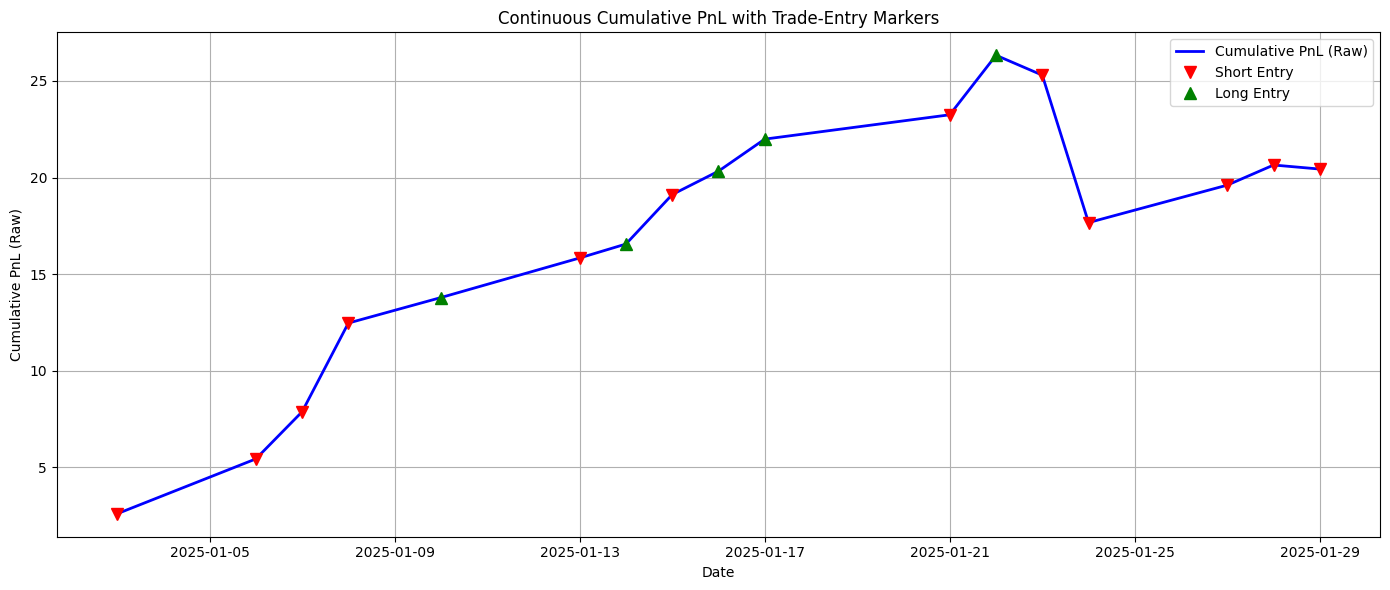

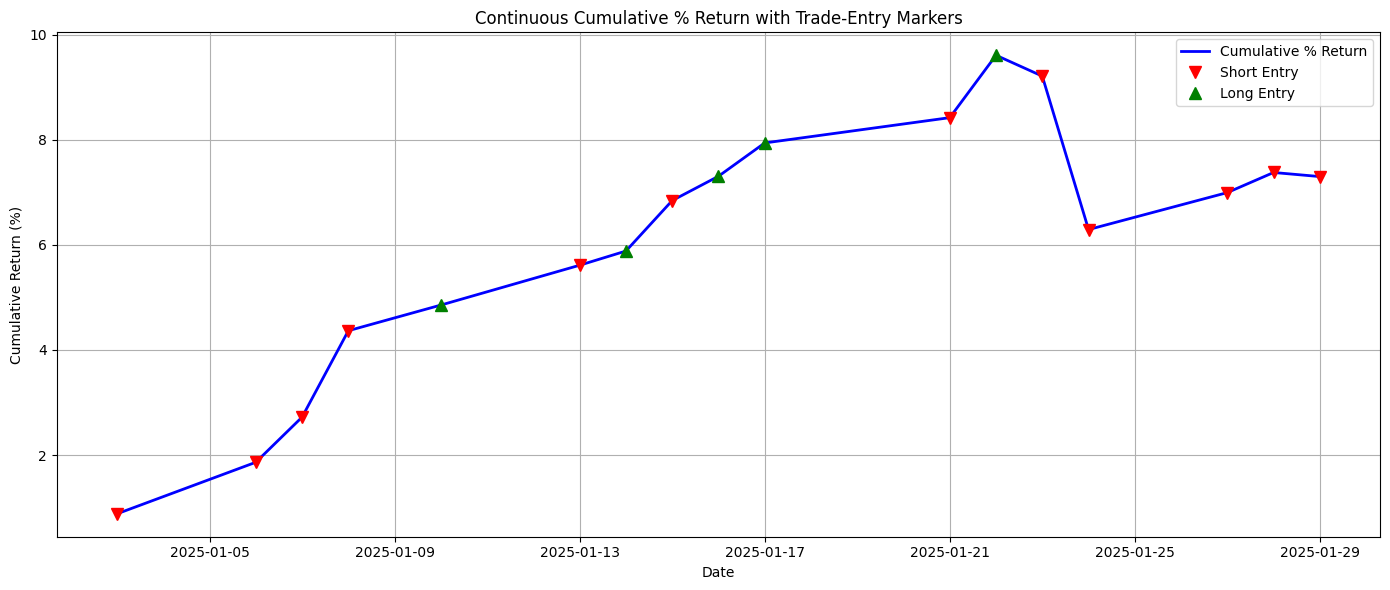

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# ==============================================================================
# 1. Prepare the ML dataset for Trade-Entry Classification
# ==============================================================================
# We assume df_test_poly already exists and contains:
#   - "Date": datetime, "Actual": the unscaled actual price,
#   - "WeightedVote": our ensemble vote (weighted sum of signs),
#   - For each model in best_model_names, a column "{model}_deriv" (the derivative evaluated at that date).
# (If any derivative column is missing, it should have been computed already.)

# Create target: Next day's return, then assign OptimalSignal:
#   - Label as 1 (Long) if next day return > threshold
#   - Label as -1 (Short) if next day return < -threshold
#   - Otherwise 0 (Flat)
threshold = 0.001  # 0.1% threshold
df_ml = df_test_poly.copy().reset_index(drop=True)

# Compute next day's actual price and return:
df_ml['Next_Actual'] = df_ml['Actual'].shift(-1)
df_ml['Next_Return'] = (df_ml['Next_Actual'] - df_ml['Actual']) / df_ml['Actual']

def label_signal(ret, thresh=threshold):
    if ret > thresh:
        return 1
    elif ret < -thresh:
        return -1
    else:
        return 0

df_ml['OptimalSignal'] = df_ml['Next_Return'].apply(label_signal)

# Also compute a lagged return as an extra feature:
df_ml['Lag_Return'] = df_ml['Actual'].pct_change()

# Drop the first row (NaN lag) and the last row (NaN next actual)
df_ml = df_ml.dropna(subset=['Lag_Return', 'Next_Return']).reset_index(drop=True)

# ==============================================================================
# 2. Build Feature Matrix and Target Vector for Classification
# ==============================================================================
# Use features from our ensemble and some additional information.
# Features used:
#   - "WeightedVote"
#   - "Lag_Return"
#   - "Actual" (price level)
#   - Each model's derivative: e.g., "LSTM_deriv", "GRU_deriv", etc.
feature_cols = ["WeightedVote", "Lag_Return", "Actual"]
for model in best_model_names:
    col = f"{model}_deriv"
    if col in df_ml.columns:
        feature_cols.append(col)
    else:
        # In case the derivative column is missing (it should not be), fill with 0.
        df_ml[col] = 0.0
        feature_cols.append(col)

X = df_ml[feature_cols].copy()
y = df_ml["OptimalSignal"].copy()

# ==============================================================================
# 3. Split the Data into Training and Testing Sets
# ==============================================================================
# For example, we use 70% for training and 30% for testing (by index order).
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, shuffle=False)

# ==============================================================================
# 4. Train a RandomForest Classifier to Predict the Optimal Trade Signal
# ==============================================================================
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate on the test set:
y_pred = rf_clf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# For further use, predict on the entire ML dataset.
df_ml['PredictedSignal'] = rf_clf.predict(X)

# ==============================================================================
# 5. Simulate Trading Based on the ML-Predicted Signals
# ==============================================================================
# We will use the predicted signal on day t to hold a position from day t to t+1.
# For simulation, work on df_ml (which is aligned with df_test_poly for the period we have labels).
df_trade = df_ml.copy().reset_index(drop=True)
df_trade = df_trade.iloc[:-1].copy()  # drop last day since no next-day price

# Next-day actual price and returns:
df_trade['Next_Actual'] = df_ml['Actual'].shift(-1).iloc[:-1].values
df_trade['Price_Change'] = df_trade['Next_Actual'] - df_trade['Actual']
df_trade['Price_Return'] = df_trade['Price_Change'] / df_trade['Actual']

# Use the predicted signal from our ML classifier:
df_trade['TradeSignal'] = df_trade['PredictedSignal']

# Compute daily P&L and daily returns:
df_trade['Daily_PnL'] = df_trade['TradeSignal'] * df_trade['Price_Change']
df_trade['Daily_Return'] = df_trade['TradeSignal'] * df_trade['Price_Return']

# Compute cumulative values:
df_trade['Cumulative_PnL'] = df_trade['Daily_PnL'].cumsum()
df_trade['Cumulative_Return'] = (1 + df_trade['Daily_Return']).cumprod() - 1

print("\n=== Trading Simulation Summary (ML-based) ===")
print("Final Cumulative Raw PnL: {:.4f}".format(df_trade['Cumulative_PnL'].iloc[-1]))
print("Final Cumulative % Return: {:.2%}".format(df_trade['Cumulative_Return'].iloc[-1]))
print("\nTrade Signal Counts:")
print(df_trade['TradeSignal'].value_counts())

# ==============================================================================
# 6. Plot Continuous Cumulative Revenue Curves with Trade-Entry Markers
# ==============================================================================
# We now plot continuous lines for cumulative PnL and cumulative % return.
# We also mark the days when the ML model suggests a trade entry.
# Define marker styles for Long and Short entries:
marker_styles = {1: {'color': 'green', 'marker': '^', 'label': 'Long Entry'},
                 -1: {'color': 'red', 'marker': 'v', 'label': 'Short Entry'}}

# Plot cumulative PnL (raw)
plt.figure(figsize=(14, 6))
plt.plot(df_trade["Date"], df_trade["Cumulative_PnL"], color='blue', linewidth=2, label="Cumulative PnL (Raw)")
# Mark trade entries
for idx, row in df_trade.iterrows():
    if row['TradeSignal'] in [1, -1]:
        style = marker_styles[row['TradeSignal']]
        plt.plot(row["Date"], row["Cumulative_PnL"], linestyle='none',
                 marker=style['marker'], color=style['color'], markersize=8,
                 label=style['label'] if idx==df_trade[df_trade['TradeSignal']==row['TradeSignal']].index[0] else "")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (Raw)")
plt.title("Continuous Cumulative PnL with Trade-Entry Markers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot cumulative % Return
plt.figure(figsize=(14, 6))
plt.plot(df_trade["Date"], df_trade["Cumulative_Return"] * 100, color='blue', linewidth=2, label="Cumulative % Return")
# Mark trade entries
for idx, row in df_trade.iterrows():
    if row['TradeSignal'] in [1, -1]:
        style = marker_styles[row['TradeSignal']]
        plt.plot(row["Date"], row["Cumulative_Return"] * 100, linestyle='none',
                 marker=style['marker'], color=style['color'], markersize=8,
                 label=style['label'] if idx==df_trade[df_trade['TradeSignal']==row['TradeSignal']].index[0] else "")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.title("Continuous Cumulative % Return with Trade-Entry Markers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Composite Confidences (Non-ML population voting):
Boost: 0.3618
SVM: 0.2052
GRU: 0.5175
N-BEATS: 0.5042
N-HITS: 0.4440

Non-ML Trading Strategy Summary:
Final Cumulative PnL (Raw): -5.7900
Signal Counts:
Signal
-1    8
 1    6
 0    4
Name: count, dtype: int64


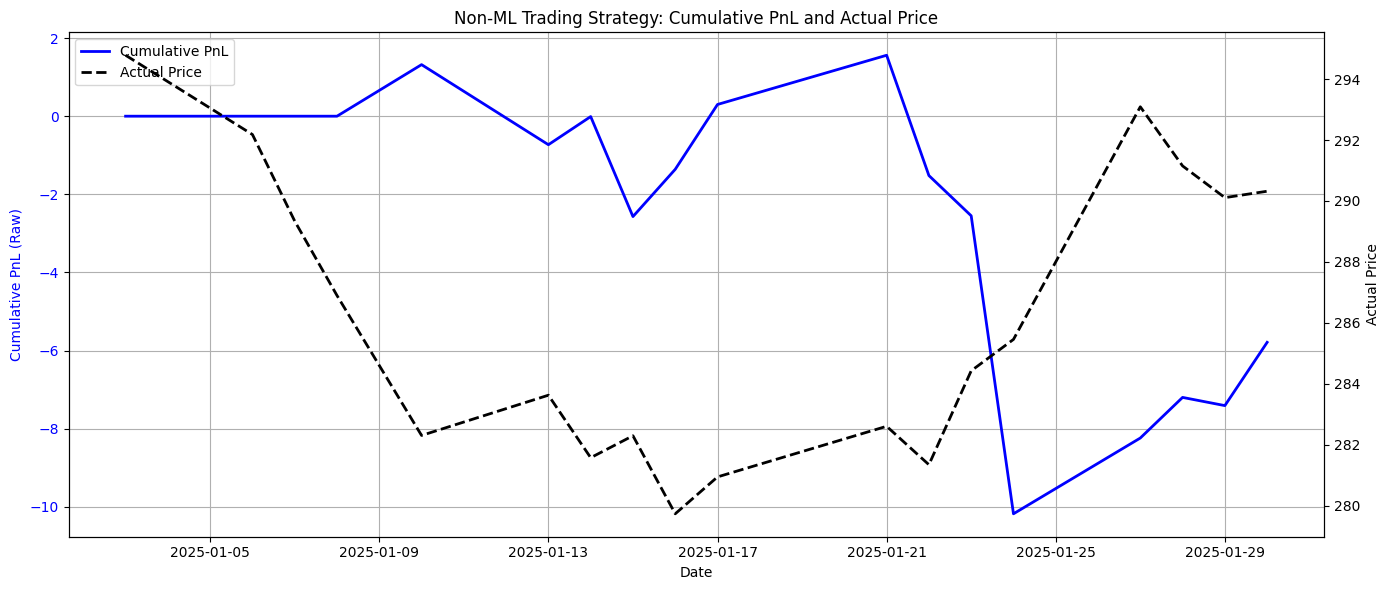

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =============================================================================
# PRELIMINARY: Assume the following are already defined:
#   - best_model_names: list of best model names (e.g. ['LSTM', 'GRU', 'RNN', ...])
#   - selected_models_confidence: dictionary with original confidence values for each model 
#         (from price prediction errors via population voting), e.g.,
#         {"LSTM": 0.25, "GRU": 0.20, "RNN": 0.15, ...}
#   - best_poly_info: dictionary keyed by model name containing best polynomial info,
#         including "val_mse" and the fitted "coeffs" for that model.
#   - df_test_poly: a DataFrame for the test period that contains at least:
#         "Date", "Actual" (the actual unscaled price), and "mdates_num" (numeric dates)
#
# Additionally, for each model we expect a derivative column (e.g., "LSTM_deriv").
# If not already computed, we will compute them below.
# =============================================================================

# ---------------------------
# 1. Additional Confidence Calculations
# ---------------------------
# (a) Confidence from polynomial fitting error: lower validation MSE gives higher confidence.
fit_errors = {}
for model in best_model_names:
    fit_errors[model] = best_poly_info[model]["val_mse"]
min_fit = min(fit_errors.values())
max_fit = max(fit_errors.values())
conf_fit = {}
for model in best_model_names:
    if max_fit > min_fit:
        conf_fit[model] = 1 - ((fit_errors[model] - min_fit) / (max_fit - min_fit))
    else:
        conf_fit[model] = 1.0

# (b) Confidence from polynomial gradient error:
# Compute the actual day-to-day change in price.
df_test_poly["Actual_Change"] = df_test_poly["Actual"].diff()

# For each model, compare the sign of its derivative with the sign of the actual change.
conf_grad = {}
for model in best_model_names:
    deriv_col = f"{model}_deriv"
    # If the derivative column is missing, compute it.
    if deriv_col not in df_test_poly.columns:
        coeffs = best_poly_info[model]["coeffs"]
        deriv_coeffs = np.polyder(coeffs)
        df_test_poly[deriv_col] = np.polyval(deriv_coeffs, df_test_poly["mdates_num"])
    # Only consider days where the actual change is nonzero.
    valid = df_test_poly["Actual_Change"] != 0
    valid_deriv = df_test_poly.loc[valid, deriv_col]
    valid_actual = df_test_poly.loc[valid, "Actual_Change"]
    # Count matching signs.
    matches = np.sign(valid_deriv) == np.sign(valid_actual)
    if len(matches) > 0:
        conf_grad[model] = np.mean(matches)
    else:
        conf_grad[model] = 0.0

# ---------------------------
# 2. Combine the Three Confidence Measures into a Composite Score
# ---------------------------
# We use:
#   - conf_orig: original confidence (from price prediction errors) from selected_models_confidence.
#   - conf_fit: from polynomial fitting error.
#   - conf_grad: from polynomial gradient accuracy.
w1, w2, w3 = 0.4, 0.3, 0.3
composite_conf = {}
for model in best_model_names:
    conf_orig = selected_models_confidence.get(model, 0)
    composite_conf[model] = w1 * conf_orig + w2 * conf_fit[model] + w3 * conf_grad[model]

print("Composite Confidences (Non-ML population voting):")
for model in best_model_names:
    print(f"{model}: {composite_conf[model]:.4f}")

# ---------------------------
# 3. Determine Daily Trading Signal via Population Voting
# ---------------------------
# Each model votes by taking the sign of its derivative.
# Its vote is weighted by its composite confidence.
total_weight = sum(composite_conf[model] for model in best_model_names)

def population_signal(row, models, comp_conf, threshold_ratio=0.2):
    vote = sum(comp_conf[model] * np.sign(row[f"{model}_deriv"]) for model in models)
    threshold = threshold_ratio * total_weight
    if vote >= threshold:
        return 1    # Signal to go long
    elif vote <= -threshold:
        return -1   # Signal to go short
    else:
        return 0    # No position

df_test_poly["Signal"] = df_test_poly.apply(lambda row: population_signal(row, best_model_names, composite_conf), axis=1)

# ---------------------------
# 4. Simulate Trading Based on the Daily Signal
# ---------------------------
# We use the signal on day t to hold a position from day t to day t+1.
# (Because we are comparing against actual prices, we can use the actual price curve as a benchmark.)
# We'll drop the first row (because of the diff) and the last row (no next-day price).
df_trading = df_test_poly.copy().reset_index(drop=True)
df_trading = df_trading.iloc[1:-1].copy()

# Use next day's actual price.
df_trading['Next_Actual'] = df_test_poly["Actual"].shift(-1).iloc[1:-1].values
df_trading['Price_Change'] = df_trading['Next_Actual'] - df_trading['Actual']
df_trading['Daily_PnL'] = df_trading['Signal'] * df_trading['Price_Change']
df_trading['Cumulative_PnL'] = df_trading['Daily_PnL'].cumsum()

print("\nNon-ML Trading Strategy Summary:")
print("Final Cumulative PnL (Raw): {:.4f}".format(df_trading['Cumulative_PnL'].iloc[-1]))
print("Signal Counts:")
print(df_trading['Signal'].value_counts())

# ---------------------------
# 5. Plot Dual-Axis Diagram: Cumulative PnL & Actual Price Curve
# ---------------------------
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left axis: plot continuous cumulative PnL.
ax1.plot(df_trading["Date"], df_trading["Cumulative_PnL"], color="blue", linewidth=2, label="Cumulative PnL")
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL (Raw)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

# Right axis: plot the actual price curve.
ax2 = ax1.twinx()
ax2.plot(df_trading["Date"], df_trading["Actual"], color="black", linestyle="--", linewidth=2, label="Actual Price")
ax2.set_ylabel("Actual Price", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Combine legends from both axes.
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Non-ML Trading Strategy: Cumulative PnL and Actual Price")
plt.tight_layout()
plt.show()


Normalized Composite Confidences:
Boost: 0.1780
SVM: 0.1010
GRU: 0.2546
N-BEATS: 0.2480
N-HITS: 0.2184

Non-ML Trading Strategy Summary:
Final Cumulative PnL (Raw): -5.7900
Final Cumulative % Return: -2.10%
Signal Counts:
Signal
-1    8
 1    6
 0    4
Name: count, dtype: int64


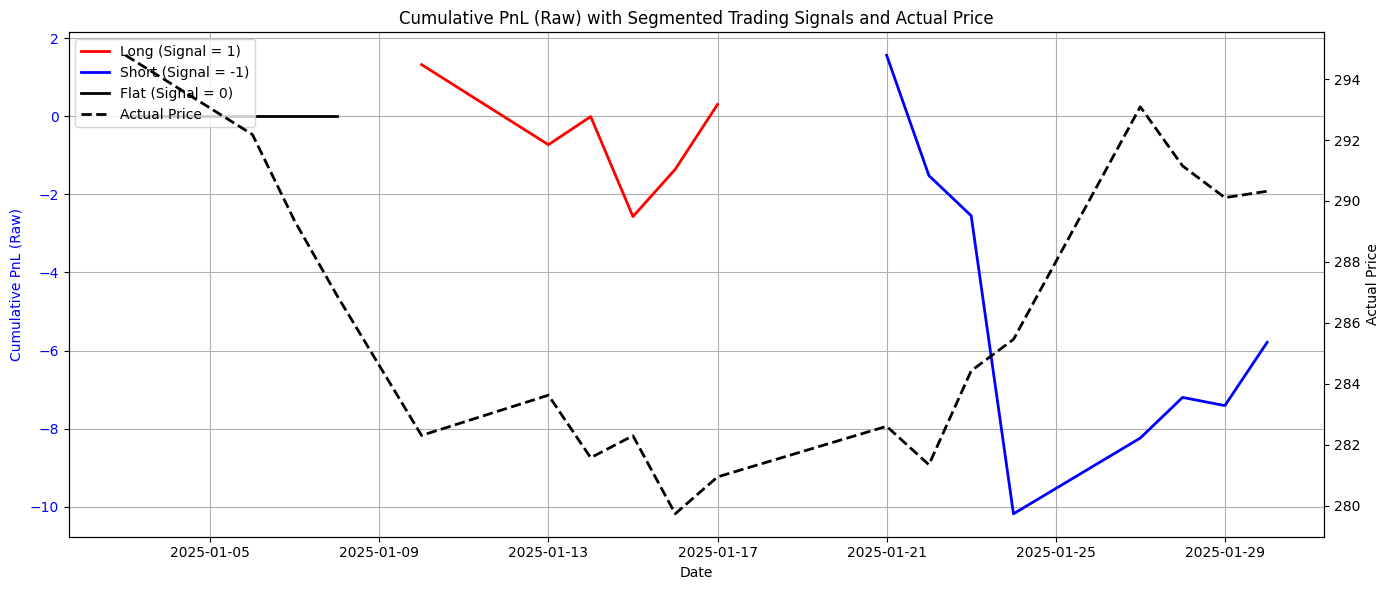

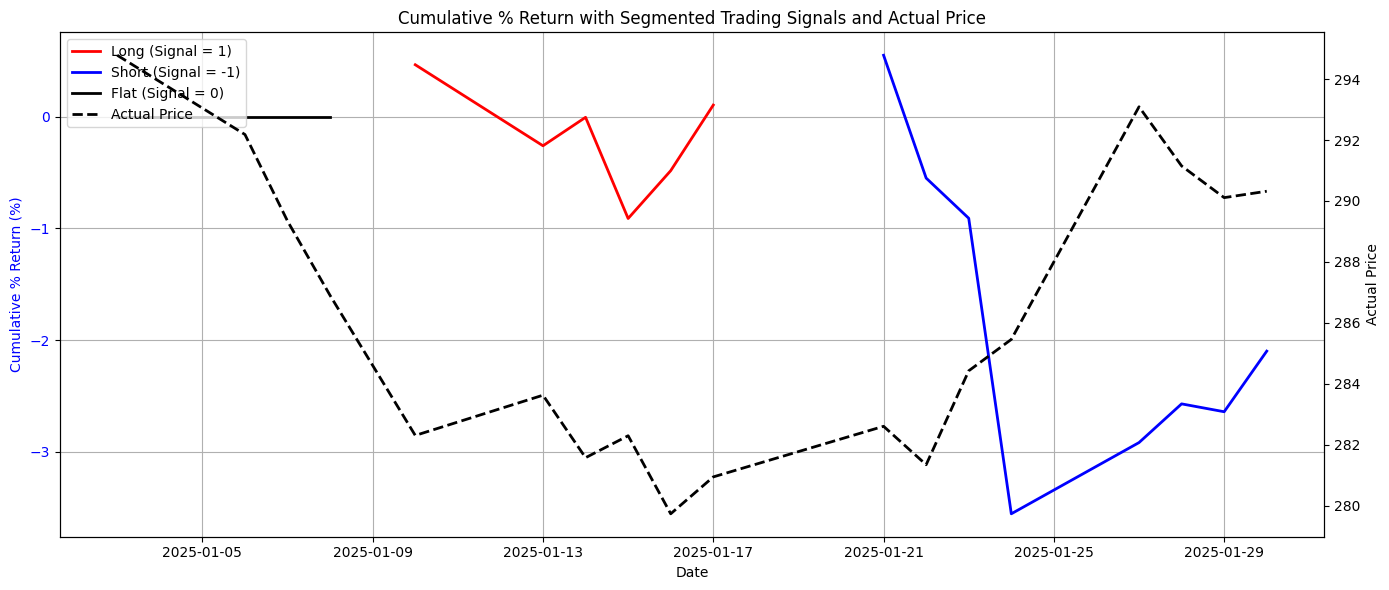

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =============================================================================
# PRELIMINARY ASSUMPTIONS:
#   - best_model_names: list of best model names (e.g. ['LSTM','GRU','RNN','CNN','Transformer'])
#   - selected_models_confidence: dict with original confidence for each model (e.g., from price-prediction errors)
#   - best_poly_info: dict keyed by model name with best polynomial information, including "val_mse" and "coeffs"
#   - df_test_poly: DataFrame for the test period that includes at least:
#         "Date" (datetime), "Actual" (the actual unscaled price), and "mdates_num" (numeric dates)
#
# For each model, we expect a derivative column (e.g., "LSTM_deriv"). If not present, we will compute it.
# =============================================================================

# ---------------------------
# 1. Compute Additional Confidence Measures
# ---------------------------

# (a) Fitting confidence: lower validation MSE gives higher confidence.
fit_errors = {}
for model in best_model_names:
    fit_errors[model] = best_poly_info[model]["val_mse"]
min_fit = min(fit_errors.values())
max_fit = max(fit_errors.values())
conf_fit = {}
for model in best_model_names:
    if max_fit > min_fit:
        conf_fit[model] = 1 - ((fit_errors[model] - min_fit) / (max_fit - min_fit))
    else:
        conf_fit[model] = 1.0

# (b) Gradient confidence: compare the sign of the model’s fitted derivative with the actual day-to-day price change.
# First, compute the actual day-to-day change in price.
df_test_poly["Actual_Change"] = df_test_poly["Actual"].diff()

conf_grad = {}
for model in best_model_names:
    deriv_col = f"{model}_deriv"
    # Compute the derivative column if not already present.
    if deriv_col not in df_test_poly.columns:
        coeffs = best_poly_info[model]["coeffs"]
        deriv_coeffs = np.polyder(coeffs)
        df_test_poly[deriv_col] = np.polyval(deriv_coeffs, df_test_poly["mdates_num"])
    valid = df_test_poly["Actual_Change"] != 0  # only consider days with nonzero change
    valid_deriv = df_test_poly.loc[valid, deriv_col]
    valid_actual = df_test_poly.loc[valid, "Actual_Change"]
    matches = np.sign(valid_deriv) == np.sign(valid_actual)
    if len(matches) > 0:
        conf_grad[model] = np.mean(matches)
    else:
        conf_grad[model] = 0.0

# ---------------------------
# 2. Compute and Normalize Composite Confidence
# ---------------------------
# We combine:
#   - conf_orig: from selected_models_confidence (original)
#   - conf_fit: from polynomial fitting error
#   - conf_grad: from gradient accuracy
w1, w2, w3 = 0.4, 0.3, 0.3

composite_conf = {}
for model in best_model_names:
    conf_orig = selected_models_confidence.get(model, 0)
    composite_conf[model] = w1 * conf_orig + w2 * conf_fit[model] + w3 * conf_grad[model]

# Normalize so that the sum for all five models equals 1.
total_conf = sum(composite_conf[model] for model in best_model_names)
for model in best_model_names:
    composite_conf[model] /= total_conf

print("Normalized Composite Confidences:")
for model in best_model_names:
    print(f"{model}: {composite_conf[model]:.4f}")

# ---------------------------
# 3. Determine Daily Trading Signal via Population Voting
# ---------------------------
# Each model votes by taking the sign of its derivative (if not available, it's computed above).
# Its vote is weighted by its normalized composite confidence.
total_weight = sum(composite_conf[model] for model in best_model_names)  # now equals 1

def population_signal(row, models, comp_conf, threshold_ratio=0.2):
    weighted_sum = sum(comp_conf[model] * np.sign(row[f"{model}_deriv"]) for model in models)
    threshold = threshold_ratio * total_weight  # threshold_ratio * 1
    if weighted_sum >= threshold:
        return 1    # go long
    elif weighted_sum <= -threshold:
        return -1   # go short
    else:
        return 0    # no position

df_test_poly["Signal"] = df_test_poly.apply(lambda row: population_signal(row, best_model_names, composite_conf), axis=1)

# ---------------------------
# 4. Simulate Trading
# ---------------------------
# Use the signal on day t to hold a position from day t to day t+1.
# We drop the first row (because of diff) and the last row (no next-day price).
df_trading = df_test_poly.copy().reset_index(drop=True)
df_trading = df_trading.iloc[1:-1].copy()

# Next-day actual price and compute daily PnL.
df_trading['Next_Actual'] = df_test_poly["Actual"].shift(-1).iloc[1:-1].values
df_trading['Price_Change'] = df_trading['Next_Actual'] - df_trading['Actual']
df_trading['Daily_PnL'] = df_trading['Signal'] * df_trading['Price_Change']
df_trading['Daily_Return'] = df_trading['Price_Change'] / df_trading['Actual'] * df_trading['Signal']

df_trading['Cumulative_PnL'] = df_trading['Daily_PnL'].cumsum()
df_trading['Cumulative_Return'] = (1 + df_trading['Daily_Return']).cumprod() - 1

print("\nNon-ML Trading Strategy Summary:")
print("Final Cumulative PnL (Raw): {:.4f}".format(df_trading['Cumulative_PnL'].iloc[-1]))
print("Final Cumulative % Return: {:.2%}".format(df_trading['Cumulative_Return'].iloc[-1]))
print("Signal Counts:")
print(df_trading['Signal'].value_counts())

# ---------------------------
# 5. Helper: Segment the Continuous Curve by Trading Signal
# ---------------------------
def get_segments_continuous(df, signal_col="Signal"):
    segments = []
    start_idx = 0
    current_signal = df.iloc[0][signal_col]
    for i in range(1, len(df)):
        if df.iloc[i][signal_col] != current_signal:
            segments.append((start_idx, i-1, current_signal))
            start_idx = i
            current_signal = df.iloc[i][signal_col]
    segments.append((start_idx, len(df)-1, current_signal))
    return segments

segments = get_segments_continuous(df_trading, "Signal")

# Define colors for the positions:
# Long (1) in red, Short (-1) in blue, Flat (0) in black.
signal_colors = {1: 'red', -1: 'blue', 0: 'black'}

# ---------------------------
# 6. Plot Dual-Axis Diagrams with Segmented Coloring
# ---------------------------

# Plot for Cumulative PnL (Raw)
fig, ax1 = plt.subplots(figsize=(14, 6))
for (start, end, sig) in segments:
    seg_dates = df_trading["Date"].iloc[start:end+1]
    seg_values = df_trading["Cumulative_PnL"].iloc[start:end+1]
    ax1.plot(seg_dates, seg_values, color=signal_colors[sig], linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL (Raw)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

# Right-hand axis: Actual price curve.
ax2 = ax1.twinx()
ax2.plot(df_trading["Date"], df_trading["Actual"], color="black", linestyle="--", linewidth=2)
ax2.set_ylabel("Actual Price", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Build a combined legend.
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Long (Signal = 1)'),
    Line2D([0], [0], color='blue', lw=2, label='Short (Signal = -1)'),
    Line2D([0], [0], color='black', lw=2, label='Flat (Signal = 0)'),
    Line2D([0], [0], color='black', linestyle='--', lw=2, label='Actual Price')
]
ax1.legend(handles=legend_elements, loc="upper left")

ax1.set_title("Cumulative PnL (Raw) with Segmented Trading Signals and Actual Price")
plt.tight_layout()
plt.show()

# Plot for Cumulative % Return (in %)
fig, ax1 = plt.subplots(figsize=(14, 6))
for (start, end, sig) in segments:
    seg_dates = df_trading["Date"].iloc[start:end+1]
    seg_returns = df_trading["Cumulative_Return"].iloc[start:end+1] * 100
    ax1.plot(seg_dates, seg_returns, color=signal_colors[sig], linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative % Return (%)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(df_trading["Date"], df_trading["Actual"], color="black", linestyle="--", linewidth=2)
ax2.set_ylabel("Actual Price", color="black")
ax2.tick_params(axis="y", labelcolor="black")

ax1.legend(handles=legend_elements, loc="upper left")
ax1.set_title("Cumulative % Return with Segmented Trading Signals and Actual Price")
plt.tight_layout()
plt.show()


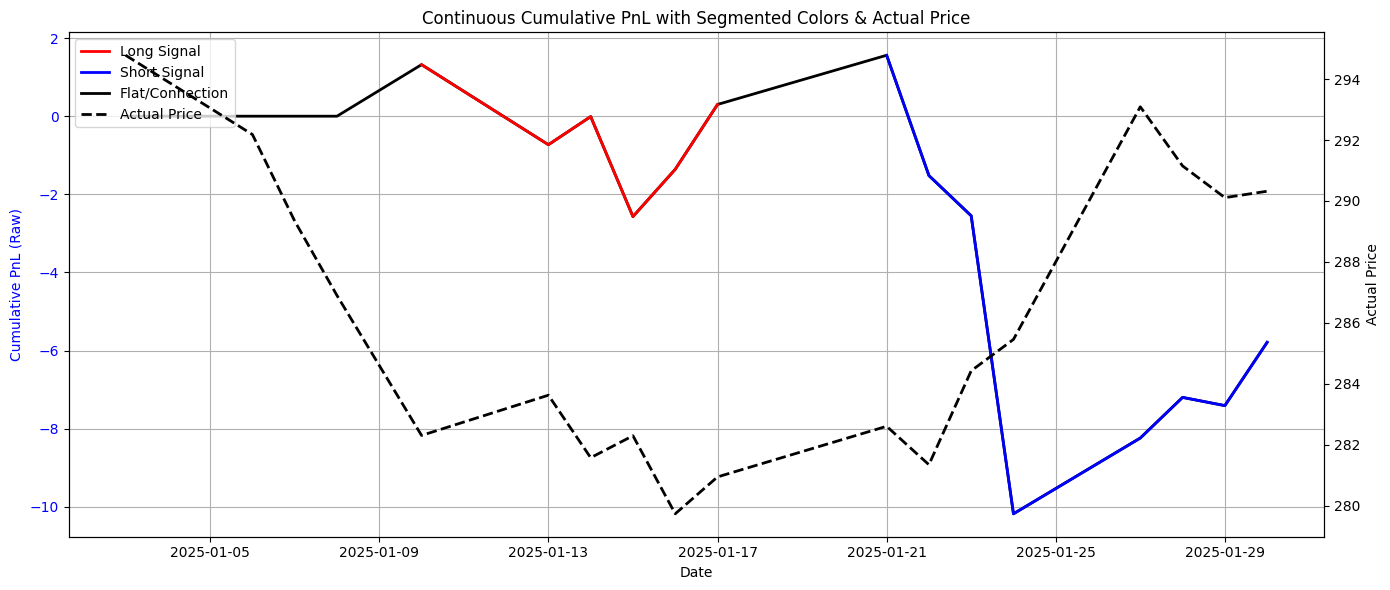

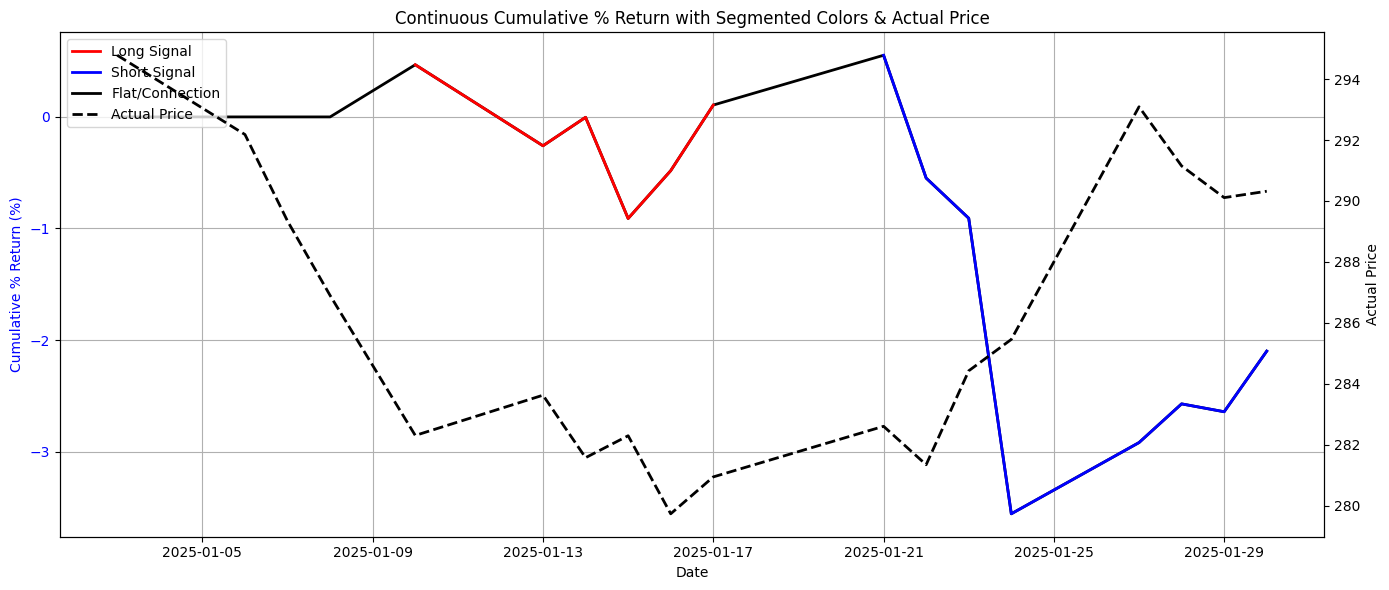

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------------------------
# (Assuming the previous steps have been executed:)
# best_model_names, selected_models_confidence, best_poly_info, df_test_poly
# are already defined and the "Signal" column is computed.
#
# Also, we have simulated trading in df_trading:
#   df_trading contains "Date", "Actual", "Daily_PnL", "Cumulative_PnL", "Cumulative_Return", and "Signal".
# ---------------------------

# Helper: Segment the continuous curve by trading signal.
def get_segments_continuous(df, signal_col="Signal"):
    segments = []
    start_idx = 0
    current_signal = df.iloc[0][signal_col]
    for i in range(1, len(df)):
        if df.iloc[i][signal_col] != current_signal:
            segments.append((start_idx, i-1, current_signal))
            start_idx = i
            current_signal = df.iloc[i][signal_col]
    segments.append((start_idx, len(df)-1, current_signal))
    return segments

segments = get_segments_continuous(df_trading, "Signal")

# Define colors for the positions (only for overlaying colored segments):
# We'll overlay red for long (1) and blue for short (-1).
overlay_colors = {1: 'red', -1: 'blue'}  # Flat (0) segments remain in black.

# ---------------------------
# Plotting Cumulative PnL (Raw) with Dual Axes
# ---------------------------
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the full cumulative PnL as a continuous black line.
ax1.plot(df_trading["Date"], df_trading["Cumulative_PnL"], color="black", linewidth=2, label="Cumulative PnL (Base)")

# Overlay colored segments where signal is active.
for (start, end, sig) in segments:
    if sig in overlay_colors:  # Only overlay for long or short.
        seg_dates = df_trading["Date"].iloc[start:end+1]
        seg_values = df_trading["Cumulative_PnL"].iloc[start:end+1]
        ax1.plot(seg_dates, seg_values, color=overlay_colors[sig], linewidth=2, label=("Long" if sig==1 else "Short"))

ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL (Raw)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

# Plot the actual price curve on the right-hand axis.
ax2 = ax1.twinx()
ax2.plot(df_trading["Date"], df_trading["Actual"], color="black", linestyle="--", linewidth=2, label="Actual Price")
ax2.set_ylabel("Actual Price", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Combine legends from both axes.
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Long Signal'),
    Line2D([0], [0], color='blue', lw=2, label='Short Signal'),
    Line2D([0], [0], color='black', lw=2, label='Flat/Connection'),
    Line2D([0], [0], color='black', linestyle='--', lw=2, label='Actual Price')
]
ax1.legend(handles=legend_elements, loc="upper left")
ax1.set_title("Continuous Cumulative PnL with Segmented Colors & Actual Price")
plt.tight_layout()
plt.show()

# ---------------------------
# Plotting Cumulative % Return with Dual Axes
# ---------------------------
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the full cumulative % return as a continuous black line.
ax1.plot(df_trading["Date"], df_trading["Cumulative_Return"] * 100, color="black", linewidth=2, label="Cumulative % Return (Base)")

# Overlay colored segments.
for (start, end, sig) in segments:
    if sig in overlay_colors:
        seg_dates = df_trading["Date"].iloc[start:end+1]
        seg_returns = df_trading["Cumulative_Return"].iloc[start:end+1] * 100
        ax1.plot(seg_dates, seg_returns, color=overlay_colors[sig], linewidth=2, label=("Long" if sig==1 else "Short"))

ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative % Return (%)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

# Plot the actual price curve on the right-hand axis.
ax2 = ax1.twinx()
ax2.plot(df_trading["Date"], df_trading["Actual"], color="black", linestyle="--", linewidth=2, label="Actual Price")
ax2.set_ylabel("Actual Price", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Combined legend.
ax1.legend(handles=legend_elements, loc="upper left")
ax1.set_title("Continuous Cumulative % Return with Segmented Colors & Actual Price")
plt.tight_layout()
plt.show()
